In [3]:

import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
import os.path
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from heapq import nlargest

# API pull from Joe's google sheet
def gsheet_api_check(SCOPES):
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return creds

    from googleapiclient.discovery import build

def pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME):
    creds = gsheet_api_check(SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(
        spreadsheetId=SPREADSHEET_ID,
        range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print('No data found.')
    else:
        rows = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                  range=RANGE_NAME).execute()
        data = rows.get('values')
        print("COMPLETE: Data copied")
        return data

#Pulls data from the entire spreadsheet tab.
RANGE_NAME = 'Sheet1!A1:B6000'

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SPREADSHEET_ID = '12vl9HzPGpi2uGPdUefdqIBa8tyqsxk61MGLMqLn0Qz8'

data = pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME)
dai = pd.DataFrame(data[0:], columns=['price','date'])

COMPLETE: Data copied


In [4]:
# Format data
# Reorder cols
dai = dai[['date', 'price']]

# Format dtypes
dai['date'] = pd.to_datetime(dai['date'], format = '%m/%d/%Y %H:%M:%S')


# Add temp minute col to find minutes that are off schedule (minutes not ending in 8 or 3) and remove
dai['minute'] = dai['date'].dt.minute.astype(str)
dai['minute'] = [x[-1] for x in dai['minute']]
dai = dai[dai['minute'].isin(['3','8'])].reset_index(drop=True)

# Remove duplicates by only keeping rows with more than 4 minutes between entries
dai['date_shift'] = dai['date'].shift(1)
filtered_dai = dai[pd.to_timedelta(dai['date'] - dai['date_shift']) > pd.to_timedelta('4 minutes')].reset_index(drop=True)

# 1st index is incorrectly dropped because of NA resulting from shift, add back in and reassign
dai = pd.concat([pd.DataFrame(dai.loc[0]).T, filtered_dai]).reset_index(drop=True)
dai = dai[['date','price']]

# Formatting lost from merge, re-format
dai['date'] = pd.to_datetime(dai['date'], format = '%m/%d/%Y %H:%M:%S')
dai['price'] = dai['price'].astype(float)

In [5]:
def create_boundaries(df, target_diff, moving_avg_hrs, boundary_spread=0):
    '''
    Takes a df as input, finds the moving average of sell price and estimated buy price, adds a symmetric upper and lower bound subject to target_diff input, or a biased upper and lower bound if boundary_sread is not 0, returns df
    Inputs:
        df: df of dates and prices and creates boundaries based on input
        target_diff: decimal number to add to moving average to create boundaries, execute trades when price crosses this threshold
        moving_avg_hrs: num hours to base moving average on
        boundary_spread: gap between buy target_diff and sell target_diff, 
                        if positive, shifts both bounds upwards (buy more frequently, sell less frequently)
                        if negative, shifts both bounds downwards (sell more frequently, buy less frequently)
    '''
    # Work on copy of df
    df2 = df.copy()

    # split price cols into buy and sell side with .002 gap
    df2.columns = ['date','sell_price']
    df2['buy_price'] = df2['sell_price'] + .002

    # How many 5 minute intervals
    moving_avg_interval = int(round(moving_avg_hrs * 60 / 5, 0))

    # Set up moving averagees
    df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(moving_avg_interval).mean()
    df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(moving_avg_interval).mean()

    # Set up boundary trigger points
    df2['upper_bound'] = df2['moving_avg_mid_buy'] + target_diff + (boundary_spread / 2)
    df2['lower_bound'] = df2['moving_avg_mid_sell'] - target_diff + (boundary_spread / 2)

    # Shift prices so we can compare price to the previous price to measure spikes
    df2['sell_price_shift'] = df2['sell_price'].shift(1)
    df2['buy_price_shift'] = df2['buy_price'].shift(1)

    return df2



# This version can accept usdc or dai as starting unit
# This version changes how the bounds are set, opposite
# Also makes mock sell price
# Also includes boundary spread
def swing_calc(df, target_diff, moving_avg_hrs, start_coin='cross_validate', starting_bank=1000, boundary_spread=0, result_format='ending_wallet'):
    '''
    inputs: 
        df: df of prices and dates
        target_diff: 
        dai: 1 for dai, 0 for USDC
        amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
        target_diff: decimal number to add to moving average to create boundaries, exercise trades when price crosses this threshold
        moving_avg_hrs: time period in hours for moving average
        start_coin: 'dai', 'usdc', or 'cross_validate' to return the average of both
        starting_bank: starting number of tokens
        boundary_spread: gap between buy target_diff and sell target_diff, 
                         if positive, shifts both bounds upwards (buy more frequently, sell less frequently)
                         if negative, shifts both bounds downwards (sell more frequently, buy less frequently)
        result_format: 'ending_wallet', 'trade_log','num_trades' 
    '''
    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries based on moving average using inputs
    df2 = create_boundaries(df, target_diff, moving_avg_hrs, boundary_spread)
    
    # Initialize starting banks
    dai_bank = starting_bank
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0

    for (i, row) in df2.iterrows():
        # If sell price above upper bound and own DAI
        if row['sell_price'] > row['upper_bound'] and dai_bank != 0:
            # Sell dai
            dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
        
        # If below lower bound and have usdc
        elif row['buy_price'] < row['lower_bound'] and usdc_bank != 0:
            # Buy dai
            dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
    
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            else:
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if have DAI
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # If don't have DAI, Convert USDC to DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        # To cross validate, run model again starting with USDC and take the mean of the two results
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, swing_calc(df, target_diff, moving_avg_hrs, start_coin='usdc', starting_bank=starting_bank, boundary_spread=boundary_spread, result_format='ending_wallet')])
        return ending_wallet_dai_value

def create_metrics_grid(df, target_diff, moving_avg_hrs, fun, starting_bank=1000, boundary_spread=0):
    '''
    fun is function in string format ex. 'swing_calc', 'swing_calc_USDC_DAI', 'find_num_entry_points', 'joe_model'
    returns df with metrics for index and cols, suitable for heatmap
    '''
    
    col = []
    for diff in target_diff:
        row=[]
        for hr in moving_avg_hrs:
            if fun == 'swing_calc':
                row.append(swing_calc(df=df, target_diff=diff, moving_avg_hrs=hr, starting_bank=starting_bank, boundary_spread=boundary_spread))
            elif fun == 'swing_calc_USDC_DAI':
                row.append(swing_calc_USDC_DAI(df=df, target_diff=diff, moving_avg_hrs=hr, starting_bank=starting_bank, boundary_spread=boundary_spread))
            elif fun == 'find_num_entry_points':
                row.append(find_num_entry_points(df=df, target_diff=diff, moving_avg_hrs=hr))
        col.append(row)

    metrics_grid = pd.DataFrame(col, columns = moving_avg_hrs, index = target_diff)

    # Include boundary spread in name of index
    # If no spread, omit
    if boundary_spread:
        metrics_grid.index.name = boundary_spread 
    
    return metrics_grid


        
def get_statistics(df):
    '''
    takes df as input and outputs the mean, std dev, min, and max for entire df
    '''
    return pd.Series([df.index.name, df.unstack().mean(), df.unstack().std(), df.unstack().min(), df.unstack().max()],
                      index = ['spread', 'mean','std_dev','min','max'])

def find_num_entry_points(df, target_diff, moving_avg_hrs):
    '''
    Find all the potential trades if funds always available, filter out to get only the ones that initially enter trade zone
    Returns 2 element list  [num buys, num sells]
    '''
    df = create_boundaries(df, target_diff, moving_avg_hrs)
    df['buy'] = np.where(df['buy_price'] < df['lower_bound'], 1, 0)
    df['sell'] = np.where(df['sell_price'] > df['upper_bound'], 1, 0)

    results = []
    for trans in ['buy','sell']:
        # Filter for buys or sells only
        filtered_df = df[df[trans] == 1]

        # We can use the index to detect consecutive entries and mark them to remove
        filtered_df[trans] = filtered_df.index
        filtered_df[trans+'_shifted'] = filtered_df[trans].shift(1)
        filtered_df['delete_row'] = np.where(filtered_df[trans] - filtered_df[trans+'_shifted'] == 1, 1, 0)
        total_transactions = len(filtered_df[filtered_df['delete_row'] == 0])
        results.append(total_transactions)
        
    #return results[0] / sum(results)
    return results

# Execute dai purchase
def buy_dai(i, buy_price, usdc_bank, trade_log):
    dai_bank = usdc_bank / (1 + buy_price)
    usdc_bank = 0
    trades_entry = pd.Series(['buy', i, dai_bank, usdc_bank, buy_price], index = trade_log.columns)
    return dai_bank, usdc_bank, trades_entry

# Execute dai sale
def sell_dai(i, sell_price, dai_bank, trade_log):
    usdc_bank = dai_bank * (1 + sell_price)
    dai_bank = 0
    trades_entry = pd.Series(['sell', i, dai_bank, usdc_bank, sell_price], index = trade_log.columns)
    return dai_bank, usdc_bank, trades_entry

# Plot heatmap of profit for range of metrics
def plot_heatmap(df):
    plt.figure(figsize = (len(df.columns), len(df.index)))
    sns.heatmap(df, annot=True, fmt='g')

# Plot trade history using trade log
def plot_trade_log(df, boundaries, moving_avg_hrs, trade_log, cutoff_line=None):
    sns.set_style('darkgrid')

    # time series plot
    df = create_boundaries(df, boundaries, moving_avg_hrs)
    
    if cutoff_line == 'historic_avg':
        cutoff_line = [df['sell_price'].mean()]

    elif cutoff_line == 'quartiles':
        # Divide into 1st and 4th quartiles
        cutoff_line = [df['sell_price'].quantile(.25),
                       df['buy_price'].quantile(.75)]

    # Get index of trades
    sells = trade_log[trade_log['buy_or_sell'] == 'sell']['Index']
    buys = trade_log[trade_log['buy_or_sell'] == 'buy']['Index']

    # For not don't plot moving avgs
    plt.figure(figsize=(30, 12))
    to_plot = pd.melt(df, id_vars = 'date', value_vars=['sell_price','buy_price','upper_bound','lower_bound'])
    to_plot['value'] = to_plot['value'].astype(float)
    ax = sns.lineplot(x = 'date', y = 'value', hue = 'variable', data = to_plot, alpha = .6)

    # Change boundary line type
    ax.lines[2].set_linestyle("--")
    ax.lines[3].set_linestyle("--")

    if cutoff_line:
        for i, co in enumerate(cutoff_line):
            # Draw cutoff line(s)
            ax.axhline(co, c='r', ls='-.')
            # Change line type
            ax.lines[4+i].set_linestyle('--')

    # X marks the spot for trades
    sns.scatterplot('date', 'sell_price', data = df.loc[sells], marker = 'x', color='green', s=200, alpha=1, linewidth=5, label='sells')
    sns.scatterplot('date', 'buy_price', data = df.loc[buys], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label='buys')
    plt.show()


In [6]:
# This version only trades big spikes
# This version can accept usdc or dai as starting unit
# This version changes how the bounds are set, opposite
# Also makes mock sell price
# Also includes boundary spread
def big_swing_calc(df, amount, spike_amount, moving_avg_hrs, start_coin='cross_validate', result_format='ending_wallet'):
    '''
    inputs: df: df or prices and dates
            dai: 1 for dai, 0 for USDC
            amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
            target_diff: distance from moving avg's to set upper and lower trading bounds
            moving_avg_hrs: time period in hours for moving average
            boundary_spread: desired distance between target_diff for buys and sells
    result_format options : 'ending_wallet', 'trade_log','num_trades' 
    '''
    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries, estimated slippage based on moving average using inputs
    df2 = create_boundaries_no_diff(df, moving_avg_hrs)

    # Initialize starting banks
    dai_bank = amount
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0


    for (i, row) in df2.iterrows():
        # Sell dai if own dai and upward spike occurs
        if ((row['sell_price'] - row['sell_price_shift']) >= spike_amount) and dai_bank != 0:
                # Sell dai
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
        
        # Buy dai if the buy price hits the moving average (no added buffer)
        elif (row['buy_price'] <= row['moving_avg_mid_sell']) and usdc_bank != 0:
            # Buy dai
            dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
    
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            else:
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, big_swing_calc(df, amount, spike_amount, moving_avg_hrs, start_coin='usdc', result_format='ending_wallet')])
        else:
            return ending_wallet_dai_value

In [7]:
# Hybrid version- Hi/Lo price range trying to get into right currency fast, mid price range normal metrics
# This version can accept usdc or dai as starting unit
# This version changes how the bounds are set, opposite
# Also makes mock sell price
# Also includes boundary spread
def hybrid_swing_calc(df, spike_size, target_diff, moving_avg_hrs, lo_price_cutoff=None, hi_price_cutoff=None, starting_bank = 1000, start_coin='cross_validate', boundary_spread=0, result_format='ending_wallet'):
    '''
    inputs: df: df or prices and dates
            
            amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
            target_diff: distance from moving avg's to set upper and lower trading bounds
            moving_avg_hrs: time period in hours for moving average
            boundary_spread: desired distance between target_diff for buys and sells
    result_format options : 'ending_wallet', 'trade_log','num_trades' 
    '''

    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries based on moving average using inputs
    df2 = create_boundaries(df, target_diff, moving_avg_hrs, boundary_spread)

    # If no lo_price_cutoff provided, use 1st quantile of sell price
    if not lo_price_cutoff:
        lo_price_cutoff = df2['sell_price'].quantile(.25)

    # If no hi_price_cutoff provided, use 4th quantile of buy price
    if not hi_price_cutoff:
        hi_price_cutoff = df2['buy_price'].quantile(.75)

    # Initialize starting banks
    # if start with dai or cross validate, banks are set
    dai_bank = starting_bank
    usdc_bank = 0

    # if starting with usdc, convert
    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0

    # For now, price range classification does not care about where price came from only where it currently is
    # Could try verion that counts prices that just came from lo range as lo range and so on
    # Iterate through df and decide to buy, sell, or pass
    for (i, row) in df2.iterrows():
        # Lo Price Range
        if row['buy_price'] < lo_price_cutoff:
            # if price hits moving avg and have usdc
            if row['buy_price'] <= row['moving_avg_mid_buy'] and usdc_bank != 0:
                # Buy dai
                dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
            # if price spikes up and have dai
            elif (row['sell_price'] - row['sell_price_shift'] > spike_size) and dai_bank != 0 :
                # Sell dai
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)

        # Hi Price Range
        elif row['sell_price'] > hi_price_cutoff:
            # If price hits moving avg and have dai
            if row['sell_price'] >= row['moving_avg_mid_sell'] and dai_bank != 0:
                # Sell dai
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
            # if price drops big
            elif (row['buy_price'] - row['buy_price_shift'] < -spike_size) and usdc_bank != 0:
                # Buy dai
                dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
        # Mid Price Range
        else:
            # Sell dai if own dai and sell price above upper bound
            if row['sell_price'] > row['upper_bound'] and dai_bank != 0:
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
            
            # Buy dai if have usdc and below lower bound
            elif row['buy_price'] < row['lower_bound'] and usdc_bank != 0:
                dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
    
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            else:
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, hybrid_swing_calc(df, spike_size, target_diff, moving_avg_hrs, lo_price_cutoff=lo_price_cutoff, hi_price_cutoff=hi_price_cutoff, starting_bank = starting_bank, start_coin='usdc', boundary_spread=boundary_spread, result_format='ending_wallet')])

        else:
            return ending_wallet_dai_value

In [92]:

to_plot = create_metrics_grid(df=dai,
                            target_diff=[.0012, .0014, .0016, .0018, .002, .0022],
                            moving_avg_hrs=[2, 2.25, 2.5, 2.75, 3, 3.25],
                            fun='swing_calc_USDC_DAI',
                            boundary_spread = 0)

plot_heatmap(to_plot)

In [148]:
sells = hybrid_trades[hybrid_trades['Enter / Exit trade'] == 'Enter']['Index']
buys = hybrid_trades[hybrid_trades['Enter / Exit trade'] == 'Exit']['Index']

#sells = standard[standard['Enter / Exit trade'] == 'Enter']['Index']
#buys = standard[standard['Enter / Exit trade'] == 'Exit']['Index']

In [4]:
sns.set_style('darkgrid')

# time series plot
test = create_boundaries(dai, .0015, 2.5)

# Use Q1 and Q3 quartiles as cutoff points for sell_price
#q1 = np.mean([test['sell_price'].quantile(.25), test['buy_price'].quantile(.25)]) 
#q3 = np.mean([test['sell_price'].quantile(.75), test['buy_price'].quantile(.75)])  
q1 = np.mean(test['sell_price'].quantile(.25))
q3 = np.mean(test['buy_price'].quantile(.75))


plt.figure(figsize=(30, 12))
testplot = pd.melt(test, id_vars = 'date', value_vars=['sell_price','buy_price','upper_bound','lower_bound'])
testplot['value'] = testplot['value'].astype(float)
ax = sns.lineplot(x = 'date', y = 'value', hue = 'variable', data = testplot)

# Plot 1st and 4th quartile division
ax.axhline(q1, c='r', ls='-.')
ax.axhline(q3, c='r', ls='-.')

ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
sns.scatterplot('date', 'sell_price', data = test.loc[sells], marker = 'x', color='red', s=200, alpha=1, linewidth=5)
sns.scatterplot('date', 'buy_price', data = test.loc[buys], marker = 'x', color='black', s=200, alpha=1, linewidth=5)


NameError: name 'sells' is not defined

In [49]:
find_num_entry_points(dai, .002, 3)

[23, 22]

For data with a buffer of .2% and 3hr MA, we saw 22 initial entry points to buy DAI and 20 initial entry points to sell DAI.

Now investigate if big drops are more likely when the price is absolutely hi (and vice versa).  Also investigate tendencies based on price relative to moving average.

In [ ]:
###### For 4 QUANTILES
# Get price data
swings = create_boundaries(august_only, .002, 3)
swings = swings[['date','sell_price']]

# Use Q1 and Q3 quartiles as cutoff points for sell_price
q1 = swings['sell_price'].quantile(.25) 
q2 = swings['sell_price'].quantile(.5) 
q3 = swings['sell_price'].quantile(.75) 

# Set how large you want to account for on spikes and drops
spike_size = .0025

# shift sell price so we can compare obs next to each other
swings['sell_shifted'] = swings['sell_price'].shift(1)

# Mark price tier q1-q4, and shift so we can check if it came from a different zone
swings['q4_price'] = (swings['sell_price'] > q3).astype(int)
swings['q4_price_shifted'] = swings['q4_price'].shift(1)

swings['q3_price'] = ((swings['sell_price'] > q2) & (swings['sell_price'] <= q3)).astype(int)
swings['q3_price_shifted'] = swings['q3_price'].shift(1)

swings['q2_price'] = ((swings['sell_price'] > q1) & (swings['sell_price'] <= q2)).astype(int)
swings['q2_price_shifted'] = swings['q2_price'].shift(1)

swings['q1_price'] = (swings['sell_price'] <= q1).astype(int)
swings['q1_price_shifted'] = swings['q1_price'].shift(1)

# Filter dataframe for q4 prices only or entries where the previous price was q4 (just dropped)
q4_prices = swings[(swings['q4_price'] == 1) | (swings['q4_price_shifted'] == 1)]

# Filter dataframe for hi prices only or entries where the previous price was q4 
q4_prices['big_spike'] = np.where((q4_prices['sell_price'] - q4_prices['sell_shifted'] > spike_size) & (q4_prices['q4_price_shifted'] == 1), 1, 0)
q4_prices['big_drop'] = np.where((q4_prices['sell_price'] - q4_prices['sell_shifted'] < -spike_size) & (q4_prices['q4_price_shifted'] == 1), 1, 0)

# Filter dataframe for q3 prices only or entries where the previous price was h3 (just dropped)
q3_prices = swings[(swings['q3_price'] == 1) | (swings['q3_price_shifted'] == 1)]

# Filter dataframe for 13 prices only or entries where the previous price was q3 
q3_prices['big_spike'] = np.where((q3_prices['sell_price'] - q3_prices['sell_shifted'] > spike_size) & (q3_prices['q3_price_shifted'] == 1), 1, 0)
q3_prices['big_drop'] = np.where((q3_prices['sell_price'] - q3_prices['sell_shifted'] < -spike_size) & (q3_prices['q3_price_shifted'] == 1), 1, 0)

# Filter dataframe for mq2 prices only or entries where the previous price was q2 
q2_prices = swings[(swings['q2_price'] == 1) | (swings['q2_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was q2
q2_prices['big_spike'] = np.where((q2_prices['sell_price'] - q2_prices['sell_shifted'] > spike_size) & (q2_prices['q2_price_shifted'] == 1), 1, 0)
q2_prices['big_drop'] = np.where((q2_prices['sell_price'] - q2_prices['sell_shifted'] < -spike_size) & (q2_prices['q2_price_shifted'] == 1), 1, 0)


# Filter dataframe for q1 prices only or entries where the previous price was q1
q1_prices = swings[(swings['q1_price'] == 1) | (swings['q1_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was q1
q1_prices['big_spike'] = np.where((q1_prices['sell_price'] - q1_prices['sell_shifted'] > spike_size) & (q1_prices['q1_price_shifted'] == 1), 1, 0)
q1_prices['big_drop'] = np.where((q1_prices['sell_price'] - q1_prices['sell_shifted'] < -spike_size) & (q1_prices['q1_price_shifted'] == 1), 1, 0)

In [221]:
# Get price data
swings = create_boundaries(august_only, .002, 3)
swings = swings[['date','sell_price']]

# # Use Q1 and Q3 quartiles as cutoff points for sell_price
# q1 = swings['sell_price'].quantile(.25) 
# q3 = swings['sell_price'].quantile(.75) 

# splitting on avg sell price, avg buy price
q1 = swings['sell_price'].mean() 
q3 = q1 + .002 # because buy price is est .002 more

# Set how large you want to account for on spikes and drops
spike_size = .003

# shift sell price so we can compare obs next to each other
swings['sell_shifted'] = swings['sell_price'].shift(1)

# Mark price tier lo, mid, or hi, and shift so we can check if it came from a different zone
swings['hi_price'] = (swings['sell_price'] > q3).astype(int)
swings['hi_price_shifted'] = swings['hi_price'].shift(1)

swings['mid_price'] = ((swings['sell_price'] >= q1) & (swings['sell_price'] <= q3)).astype(int)
swings['mid_price_shifted'] = swings['mid_price'].shift(1)

swings['lo_price'] = (swings['sell_price'] < q1).astype(int)
swings['lo_price_shifted'] = swings['lo_price'].shift(1)

# Filter dataframe for hi prices only or entries where the previous price was hi (just dropped)
hi_prices = swings[(swings['hi_price'] == 1) | (swings['hi_price_shifted'] == 1)]

# Filter dataframe for hi prices only or entries where the previous price was hi 
hi_prices['big_spike'] = np.where((hi_prices['sell_price'] - hi_prices['sell_shifted'] > spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)
hi_prices['big_drop'] = np.where((hi_prices['sell_price'] - hi_prices['sell_shifted'] < -spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)


# Filter dataframe for mid prices only or entries where the previous price was mid 
mid_prices = swings[(swings['mid_price'] == 1) | (swings['mid_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was mid
mid_prices['big_spike'] = np.where((mid_prices['sell_price'] - mid_prices['sell_shifted'] > spike_size) & (mid_prices['mid_price_shifted'] == 1), 1, 0)
mid_prices['big_drop'] = np.where((mid_prices['sell_price'] - mid_prices['sell_shifted'] < -spike_size) & (mid_prices['mid_price_shifted'] == 1), 1, 0)


# Filter dataframe for lo prices only or entries where the previous price was lo
lo_prices = swings[(swings['lo_price'] == 1) | (swings['lo_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was lo
lo_prices['big_spike'] = np.where((lo_prices['sell_price'] - lo_prices['sell_shifted'] > spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)
lo_prices['big_drop'] = np.where((lo_prices['sell_price'] - lo_prices['sell_shifted'] < -spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)


In [106]:
### NOW USE just HI/LO
# Get price data
swings = create_boundaries(dai[dai['date'] >= '2020-08-01'], .002, 3)
swings = swings[['date','sell_price']]

# Use historic average as cutoff
cutoff = swings['sell_price'].mean()

# Set how large you want to account for on spikes and drops
spike_size = .00275

# shift sell price so we can compare obs next to each other
swings['sell_shifted'] = swings['sell_price'].shift(1)

# Mark price tier lo, mid, or hi, and shift so we can check if it came from a different zone
swings['hi_price'] = (swings['sell_price'] > cutoff).astype(int)
swings['hi_price_shifted'] = swings['hi_price'].shift(1)

swings['lo_price'] = (swings['sell_price'] <= cutoff).astype(int)
swings['lo_price_shifted'] = swings['lo_price'].shift(1)

# Filter dataframe for hi prices only or entries where the previous price was hi (just dropped)
hi_prices = swings[(swings['hi_price'] == 1) | (swings['hi_price_shifted'] == 1)]

# Filter dataframe for hi prices only or entries where the previous price was hi 
hi_prices['big_spike'] = np.where((hi_prices['sell_price'] - hi_prices['sell_shifted'] > spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)
hi_prices['big_drop'] = np.where((hi_prices['sell_price'] - hi_prices['sell_shifted'] < -spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)


# Filter dataframe for lo prices only or entries where the previous price was lo
lo_prices = swings[(swings['lo_price'] == 1) | (swings['lo_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was lo
lo_prices['big_spike'] = np.where((lo_prices['sell_price'] - lo_prices['sell_shifted'] > spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)
lo_prices['big_drop'] = np.where((lo_prices['sell_price'] - lo_prices['sell_shifted'] < -spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)

In [ ]:
#### For 4 Quantiles
# # Display df showing spikes/drops by price zone
pd.DataFrame({'Total Spikes': [q1_prices['big_spike'].sum(), 
                               q2_prices['big_spike'].sum(),
                               q3_prices['big_spike'].sum(),
                               q4_prices['big_spike'].sum()],
              'Total Drops': [q1_prices['big_drop'].sum(),
                              q2_prices['big_drop'].sum(),
                              q3_prices['big_drop'].sum(), 
                              q4_prices['big_drop'].sum()]}, index = ['Q1', 'Q2','Q3','Q4'])

In [222]:
# Display df showing spikes/drops by price zone
pd.DataFrame({'Total Spikes': [lo_prices['big_spike'].sum(), 
                              mid_prices['big_spike'].sum(),
                              hi_prices['big_spike'].sum()],
              'Total Drops': [lo_prices['big_drop'].sum(),
                              mid_prices['big_drop'].sum(),
                              hi_prices['big_drop'].sum()]}, index = ['Lo Price', 'Mid Price','Hi Price'])

Total Spikes  Total Drops
Lo Price              4            0
Mid Price             1            1
Hi Price              4            4

In [107]:
#### This is for only LO/HI zones
# Display df showing spikes/drops by price zone
pd.DataFrame({'Total Spikes': [lo_prices['big_spike'].sum(),
                         hi_prices['big_spike'].sum()],
              'Total Drops': [lo_prices['big_drop'].sum(),
                        hi_prices['big_drop'].sum()]}, index = ['Lo Price','Hi Price'])

Total Spikes  Total Drops
Lo Price             6            1
Hi Price             8            7

We see that variance increases as the price increases, and there is very little activity in the lo price zone.

In [ ]:
# ### For 4 quantiles
# Retrieve the index previous to all spikes/drops (where the spike/drop originated from) to plot 
q1_spikes = [x - 1 for x in q1_prices[q1_prices['big_spike']==1].index]
q1_drops = [x - 1 for x in q1_prices[q1_prices['big_drop']==1].index]

q2_spikes = [x - 1 for x in q2_prices[q2_prices['big_spike']==1].index]
q2_drops = [x - 1 for x in q2_prices[q2_prices['big_drop']==1].index]

q3_spikes = [x - 1 for x in q3_prices[q3_prices['big_spike']==1].index]
q3_drops = [x - 1 for x in q3_prices[q3_prices['big_drop']==1].index]

q4_spikes = [x - 1 for x in q4_prices[q4_prices['big_spike']==1].index]
q4_drops = [x - 1 for x in q4_prices[q4_prices['big_drop']==1].index]

In [223]:
# Retrieve the index previous to all spikes/drops (where the spike/drop originated from) to plot 
lo_spikes = [x - 1 for x in lo_prices[lo_prices['big_spike']==1].index]
lo_drops = [x - 1 for x in lo_prices[lo_prices['big_drop']==1].index]

mid_spikes = [x - 1 for x in mid_prices[mid_prices['big_spike']==1].index]
mid_drops = [x - 1 for x in mid_prices[mid_prices['big_drop']==1].index]

hi_spikes = [x - 1 for x in hi_prices[hi_prices['big_spike']==1].index]
hi_drops = [x - 1 for x in hi_prices[hi_prices['big_drop']==1].index]

In [108]:
#### THIS is only lo/hi
# Retrieve the index previous to all spikes/drops (where the spike/drop originated from) to plot 
lo_spikes = [x - 1 for x in lo_prices[lo_prices['big_spike']==1].index]
lo_drops = [x - 1 for x in lo_prices[lo_prices['big_drop']==1].index]

hi_spikes = [x - 1 for x in hi_prices[hi_prices['big_spike']==1].index]
hi_drops = [x - 1 for x in hi_prices[hi_prices['big_drop']==1].index]

In [ ]:
#### This is 4 quantiles
# Plot time series
plt.figure(figsize=(26, 12))
test = create_boundaries(august_only, .0015, 2.5)
ax = sns.lineplot('date','sell_price', data = test)
# Plot 1st and 4th quartile division
ax.axhline(q1, c='r')
ax.axhline(q2, c='r')
ax.axhline(q3, c='r')
# Plot all spikes/drops
sns.scatterplot('date', 'price', data = dai.loc[q1_spikes], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label = 'Q1 Spikes')
#sns.scatterplot('date', 'price', data = dai.loc[q1_drops], marker = 'x', color='darkmagenta', s=200, alpha=1, linewidth=5, label = 'Q1 Drops')
sns.scatterplot('date', 'price', data = dai.loc[q2_spikes], marker = 'x', color='greenyellow', s=200, alpha=1, linewidth=5, label = 'Q2 Spikes')
#sns.scatterplot('date', 'price', data = dai.loc[q2_drops], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label = 'Q2 Drops')
sns.scatterplot('date', 'price', data = dai.loc[q3_spikes], marker = 'x', color='blue', s=200, alpha=1, linewidth=5, label = 'Q3 Spikes')
sns.scatterplot('date', 'price', data = dai.loc[q3_drops], marker = 'x', color='magenta', s=200, alpha=1, linewidth=5, label = 'Q3 Drops')
sns.scatterplot('date', 'price', data = dai.loc[q4_spikes], marker = 'x', color='darkmagenta', s=200, alpha=1, linewidth=5, label = 'Q4 Spikes')
sns.scatterplot('date', 'price', data = dai.loc[q4_drops], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label = 'Q4 Drops')
ax.legend()

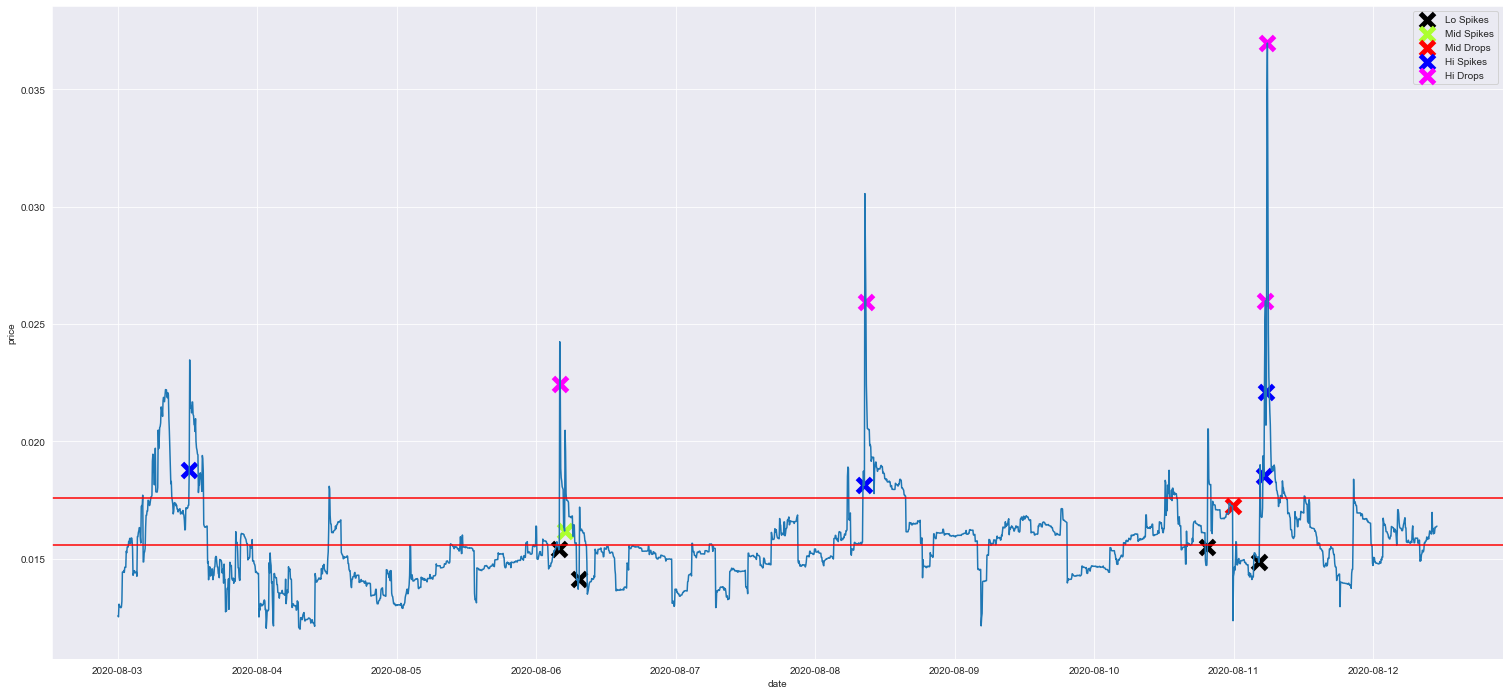

In [225]:
# Plot time series
plt.figure(figsize=(26, 12))
test = create_boundaries(august_only, .0015, 2.5)
ax = sns.lineplot('date','sell_price', data = test)
# Plot 1st and 4th quartile division
ax.axhline(q1, c='r')
ax.axhline(q3, c='r')
# Plot all spikes/drops
sns.scatterplot('date', 'price', data = dai.loc[lo_spikes], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label = 'Lo Spikes')
sns.scatterplot('date', 'price', data = dai.loc[lo_drops], marker = 'x', color='darkmagenta', s=200, alpha=1, linewidth=5, label = 'Lo Drops')
sns.scatterplot('date', 'price', data = dai.loc[mid_spikes], marker = 'x', color='greenyellow', s=200, alpha=1, linewidth=5, label = 'Mid Spikes')
sns.scatterplot('date', 'price', data = dai.loc[mid_drops], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label = 'Mid Drops')
sns.scatterplot('date', 'price', data = dai.loc[hi_spikes], marker = 'x', color='blue', s=200, alpha=1, linewidth=5, label = 'Hi Spikes')
sns.scatterplot('date', 'price', data = dai.loc[hi_drops], marker = 'x', color='magenta', s=200, alpha=1, linewidth=5, label = 'Hi Drops')
ax.legend()

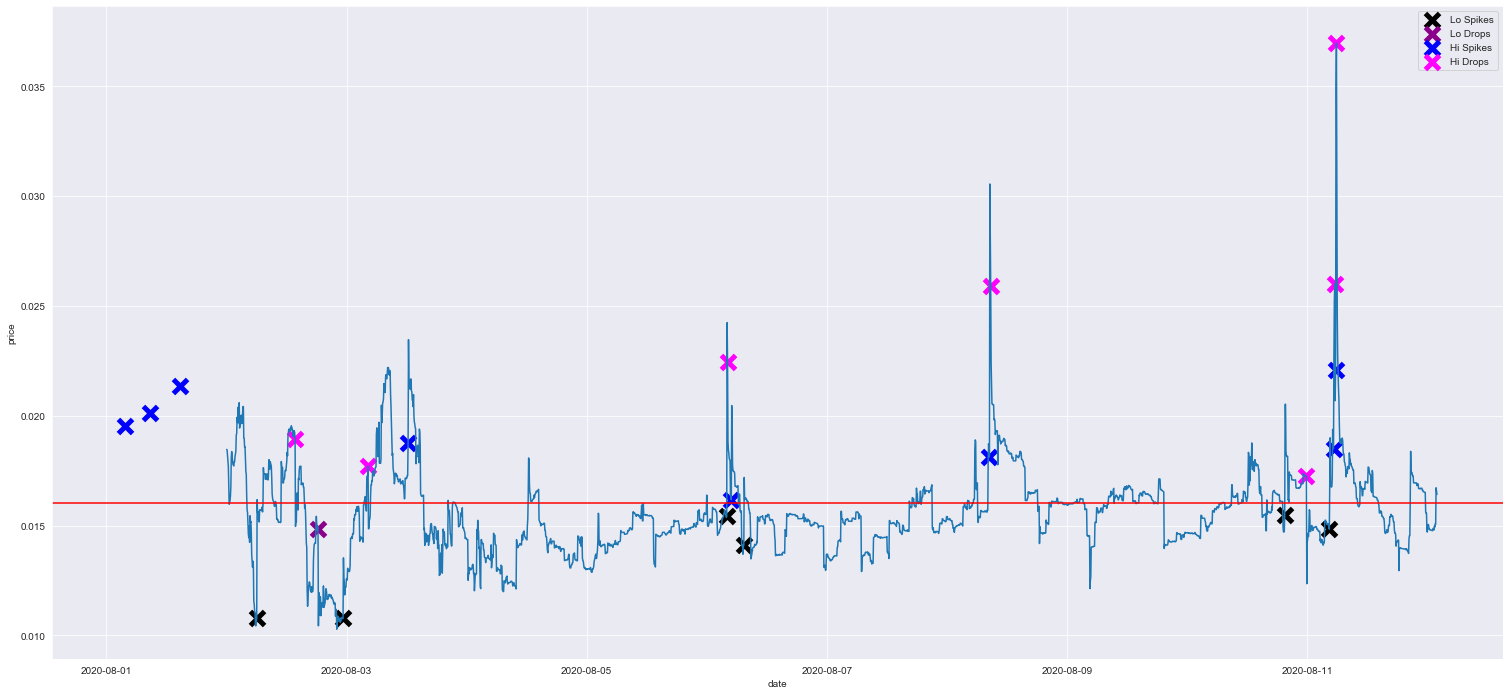

In [110]:
###### LO/HI only
# Plot time series
plt.figure(figsize=(26, 12))
test = create_boundaries(dai[dai['date'] >= '2020-08-02'], .0015, 2.5)
ax = sns.lineplot('date','sell_price', data = test)
# Plot avg
ax.axhline(cutoff, c='r')
# Plot all spikes/drops
sns.scatterplot('date', 'price', data = dai.loc[lo_spikes], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label = 'Lo Spikes')
sns.scatterplot('date', 'price', data = dai.loc[lo_drops], marker = 'x', color='darkmagenta', s=200, alpha=1, linewidth=5, label = 'Lo Drops')
sns.scatterplot('date', 'price', data = dai.loc[hi_spikes], marker = 'x', color='blue', s=200, alpha=1, linewidth=5, label = 'Hi Spikes')
sns.scatterplot('date', 'price', data = dai.loc[hi_drops], marker = 'x', color='magenta', s=200, alpha=1, linewidth=5, label = 'Hi Drops')
ax.legend()

We want to explore the rate of triggers for trades vs sells for various metrics to see if it is symmetrical, otherwise we may not have optimal boundaries set, and one side should be different from the other.

In [210]:
entry_points = create_metrics_grid(dai,
                                   [.001, .00125, .0015, .00175, .002, .00225, .0025, .00275, .003, .0035, .004, .0045, .005],
                                   [.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7, 8, 10, 12, 14],
                                   'find_num_entry_points')

In [ ]:
# Find the proportion of buys
buy_pct = entry_points.applymap(lambda x: round(x[0] / sum(x), 2))
plot_heatmap(buy_pct)
print(buy_pct.mean().mean())

This is the proportion of buys for every time that a trade is initially triggered (ignoring how long it stays in the trade zone). The data is fairly symmetrical, 45% buys overall, but some areas the proportions are skewed, and could potentially improve by changing the boundaries.

Now we will explore those boundary tweaks. We've currently been testing boundaries that are symmetrical for the buy side and sell side, but now we will experiment with different sized boundaries for each side. We will modify the create_boundaries function.

In [22]:
results_df = pd.DataFrame()
# Get stats for a range of different boundary spreads
for spread in np.arange(-.0004, .00041, .00005):
    metrics = create_metrics_grid(dai.iloc[:500],
                                   1000,
                                   [.0012, .0014, .0016, .0018, .002, .0022],
                                   [2, 2.25, 2.5, 2.75, 3, 3.25],
                                   'swing_calc',
                                   boundary_spread=spread)
    stats = get_statistics(metrics)
    results_df = results_df.append(stats, ignore_index=True)

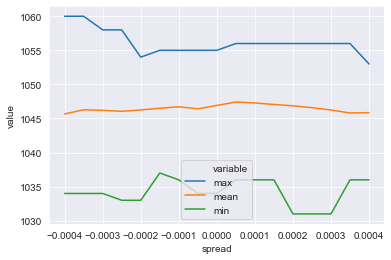

In [9]:
sns.set_style('darkgrid')
results = pd.melt(results_df, id_vars= 'spread', value_vars=['max','mean','min'])

sns.lineplot('spread', 'value', hue='variable', data = results)

In [83]:
np.mean([big_swing_calc(df=dai[1384:], is_dai=1, amount=1000, spike_amount=.003, moving_avg_hrs=3), 
        big_swing_calc(df=dai[1384:], is_dai=0, amount=1000, spike_amount=.003, moving_avg_hrs=3)])

1015.5

In [81]:
big_swing_calc(df=dai[1384:], is_dai=1, amount=1000, spike_amount=.003, moving_avg_hrs=2)

1014.0

In [82]:
swing_calc_USDC_DAI(df=dai[1384:], amount=1000, target_diff=.0015, moving_avg_hrs=3, boundary_spread=0)

1005.0

In [69]:
swing_calc(dai, is_dai=1, amount=1000, target_diff=.0015, moving_avg_hrs=3)

1052.0

In [221]:
hybrid_swing_calc(dai, is_dai=1, amount=1000, spike_size=5, target_diff=.0015, moving_avg_hrs=3)

1024.0

In [ ]:
to_plot = create_metrics_grid(df=dai[1384:],
                            amount=1000,
                            target_diff=[.0012, .0014, .0016, .0018, .002, .0022],
                            moving_avg_hrs=[2, 2.25, 2.5, 2.75, 3, 3.25],
                            fun='swing_calc_USDC_DAI',
                            boundary_spread = 0)

plot_heatmap(to_plot)

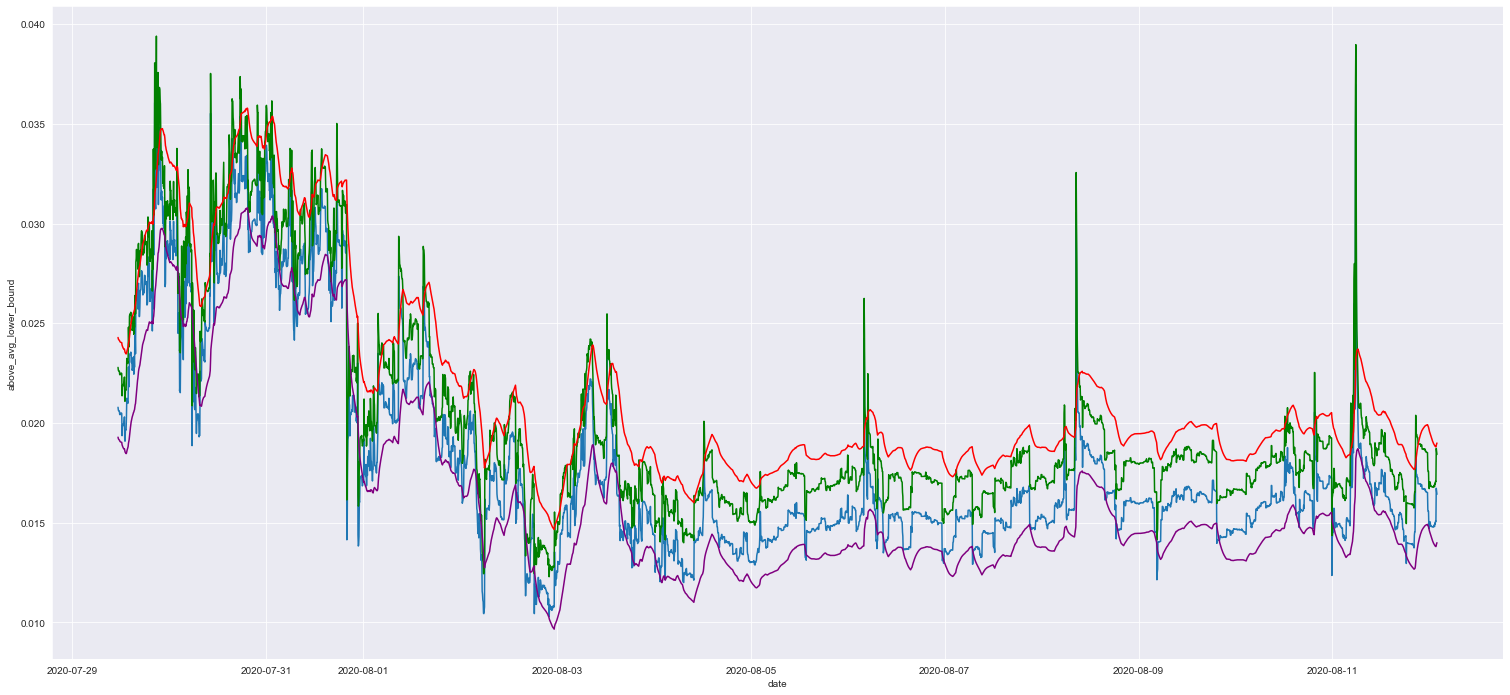

In [134]:
# Exponential moving avg

exp_ma_test = create_boundaries_joe(dai, 'exp', 3, .0015, .0015, .003, 0)
# Plot time series
plt.figure(figsize=(26, 12))

sns.lineplot('date','sell_price', data = exp_ma_test)
sns.lineplot('date','buy_price', data = exp_ma_test, c='g')
sns.lineplot('date','above_avg_upper_bound', data = exp_ma_test, c='r')
sns.lineplot('date','above_avg_lower_bound', data = exp_ma_test, c='purple')
#sns.lineplot('date','sell_price', data = test, c='r')


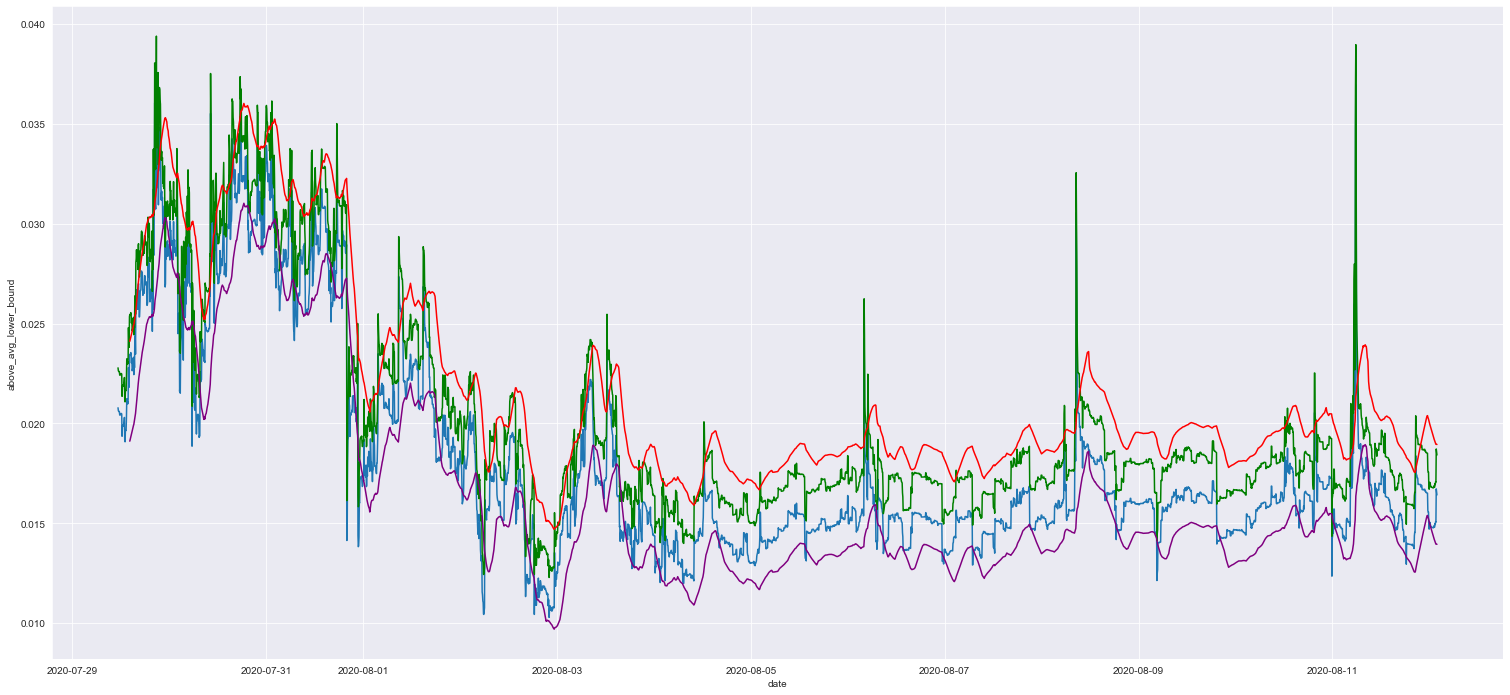

In [135]:
# Simple moving avg

exp_ma_test = create_boundaries_joe(dai, 'simple', 3, .0015, .0015, .003, 0)
# Plot time series
plt.figure(figsize=(26, 12))

sns.lineplot('date','sell_price', data = exp_ma_test)
sns.lineplot('date','buy_price', data = exp_ma_test, c='g')
sns.lineplot('date','above_avg_upper_bound', data = exp_ma_test, c='r')
sns.lineplot('date','above_avg_lower_bound', data = exp_ma_test, c='purple')
#sns.lineplot('date','sell_price', data = test, c='r')

In [86]:
def create_boundaries_joe(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound):
    '''
    df: df of dates and prices and creates boundaries based on input
    target_diff: boundaries relative to price that we want to execute trades
    moving_avg_hrs: num hours to base moving average on
    boundary_spread: gap between buy target_diff and sell target_diff, 
                     if positive, shifts both bounds upwards (buy more frequently, sell less frequently)
                     if negative, shifts both bounds downwards (sell more frequently, buy less frequently)
    '''
   
    # Work on copy of df
    df2 = df.copy()

    # split price cols into buy and sell side with .002 gap
    est_price_gap = .002
    df2.columns = ['date','sell_price']
    df2['buy_price'] = df2['sell_price'] + est_price_gap



    # How many 5 minute intervals
    sell_mvg_avg_interval = int(round(sell_mvg_avg_hrs * 60 / 5, 0))
    buy_mvg_avg_interval = int(round(buy_mvg_avg_hrs * 60 / 5, 0))
    
    # Set moving averages
    # Sell price
    if sell_mvg_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_mvg_avg_interval).mean()
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).mean()

    elif sell_mvg_avg_type == 'exp':
        # Exponential moving avg
        df2['moving_avg_mid_sell'] = df2['sell_price'].ewm(span=sell_mvg_avg_interval, min_periods=sell_mvg_avg_interval).mean()
        df2['moving_avg_mid_buy'] = df2['buy_price'].ewm(span=buy_mvg_avg_interval, min_periods=buy_mvg_avg_interval).mean()
    elif sell_mvg_avg_type == 'median':
        # Median
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_mvg_avg_interval).median()
    else:
        raise ValueError("Don't recognize sell moving average type")

    # Buy price
    if buy_mvg_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).mean()

    elif buy_mvg_avg_type == 'exp':
        # Exponential moving avg
        df2['moving_avg_mid_buy'] = df2['buy_price'].ewm(span=buy_mvg_avg_interval, min_periods=buy_mvg_avg_interval).mean()
    
    elif buy_mvg_avg_type == 'median':
        # Median
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).median()
    else:
        raise ValueError("Don't recognize buy moving average type")


    # Set up boundary trigger points
    df2['above_avg_upper_bound'] = df2['moving_avg_mid_buy'] + above_avg_upper_bound 
    df2['above_avg_lower_bound'] = df2['moving_avg_mid_sell'] - above_avg_lower_bound
    df2['below_avg_upper_bound'] = df2['moving_avg_mid_buy'] + below_avg_upper_bound 
    df2['below_avg_lower_bound'] = df2['moving_avg_mid_sell'] - below_avg_lower_bound

    # Shift prices so we can compare price to the previous price to measure spikes
    df2['sell_price_shift'] = df2['sell_price'].shift(1)
    df2['buy_price_shift'] = df2['buy_price'].shift(1)

    return df2

# Joes model
def joe_model(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'):
    '''
    inputs: df: df or prices and dates
            start_coin: 'dai', 'usdc', or 'cross_validate'. 'cross validate runs the function for both starting coins and returns the mean
            dai: 1 for dai, 0 for USDC
            amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
            target_diff: distance from moving avg's to set upper and lower trading bounds
            moving_avg_hrs: time period in hours for moving average
            boundary_spread: desired distance between target_diff for buys and sells
    result_format options : 'ending_wallet', 'trade_log','num_trades' 
    '''
    
    if start_coin == 'cross_validate' and result_format != 'ending_wallet':
        raise ValueError('Cross validation only works with ending wallet result')

    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries based on moving average using inputs
    df2 = create_boundaries_joe(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound)
    historic_avg = df2['sell_price'].mean()
    #

    # Initialize starting banks
    # For starting with Dai
    dai_bank = starting_bank
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0

    for (i, row) in df2.iterrows():
        # If market is low
        if row['sell_price'] < historic_avg:
            # If price above upper bound and own dai
            if row['sell_price'] > row['below_avg_upper_bound'] and dai_bank != 0:
                # Sell dai
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
                
            # If price below lower bound and own usdc
            elif row['buy_price'] < row['below_avg_lower_bound'] and usdc_bank != 0:
                # Buy dai
                dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
        else:
            # If price above upper bound and own dai
            if row['sell_price'] > row['above_avg_upper_bound'] and dai_bank != 0:
                # Sell dai
                dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
            # If price below lower bound and own usdc
            elif row['buy_price'] < row['above_avg_lower_bound'] and usdc_bank != 0:
                # Buy dai
                dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
                trades = trades.append(trades_entry, ignore_index = True)
        
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            elif start_coin == 'usdc':
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        # if cross validating run second function with usdc start and average results
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, joe_model(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='usdc', starting_bank=starting_bank, result_format='ending_wallet')])

        return ending_wallet_dai_value

# INCOMPLETE   
def create_metrics_grid_joe(df, moving_avg_type, moving_avg_hrs, above_avg_bounds, below_avg_upper_bound, below_avg_lower_bound):
   
    col = []
    for bound in above_avg_bounds:
        row=[]
        for hr in moving_avg_hrs:
            row.append(joe_model(df=df, moving_avg_type=moving_avg_type, moving_avg_hrs=hr, above_avg_upper_bound=bound, above_avg_lower_bound=bound, below_avg_upper_bound=below_avg_upper_bound, below_avg_lower_bound=below_avg_lower_bound))
        col.append(row)

    metrics_grid = pd.DataFrame(col, columns = moving_avg_hrs, index = above_avg_bounds)

    
    return metrics_grid

# # Plot trade history using trade log
# def plot_trade_log_joe(df, moving_avg_type, moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'):
#     sns.set_style('darkgrid')

#     # time series plot
#     df = create_boundaries_joe(df, moving_avg_type, moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound)
    
#     if cutoff_line == 'historic_avg':
#         cutoff_line = [df['sell_price'].mean()]

#     elif cutoff_line == 'quartiles':
#         # Divide into 1st and 4th quartiles
#         cutoff_line = [df['sell_price'].quantile(.25),
#                        df['buy_price'].quantile(.75)]

#     # Get index of trades
#     sells = trade_log[trade_log['buy_or_sell'] == 'sell']['Index']
#     buys = trade_log[trade_log['buy_or_sell'] == 'buy']['Index']

#     # For not don't plot moving avgs
#     plt.figure(figsize=(30, 12))
#     to_plot = pd.melt(df, id_vars = 'date', value_vars=['sell_price','buy_price','upper_bound','lower_bound'])
#     to_plot['value'] = to_plot['value'].astype(float)
#     ax = sns.lineplot(x = 'date', y = 'value', hue = 'variable', data = to_plot, alpha = .6)

#     # Change boundary line type
#     ax.lines[2].set_linestyle("--")
#     ax.lines[3].set_linestyle("--")

#     if cutoff_line:
#         for i, co in enumerate(cutoff_line):
#             # Draw cutoff line(s)
#             ax.axhline(co, c='r', ls='-.')
#             # Change line type
#             ax.lines[4+i].set_linestyle('--')

#     # X marks the spot for trades
#     sns.scatterplot('date', 'sell_price', data = df.loc[sells], marker = 'x', color='green', s=200, alpha=1, linewidth=5, label='sells')
#     sns.scatterplot('date', 'buy_price', data = df.loc[buys], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label='buys')
#     plt.show()    

In [176]:
joe_model(df=august_only, moving_avg_type='simple', start_coin='cross_validate', moving_avg_hrs=3, above_avg_upper_bound=.0015, above_avg_lower_bound=.0015, below_avg_upper_bound=.003, below_avg_lower_bound=0, result_format='ending_wallet')

in joe_model 0.5 0
in create bounds 0.5 0
in joe_model 0.5 0
in create bounds 0.5 0


1032.5

In [12]:
august_only = dai[dai['date'] >= '2020-08-03']
joe_model(df = august_only, 
        moving_avg_type = 'simple',
        moving_avg_hrs=4.75, 
        above_avg_upper_bound=.0024,
        above_avg_lower_bound=.0024, 
        below_avg_upper_bound=.003, 
        below_avg_lower_bound=0)

1040.5

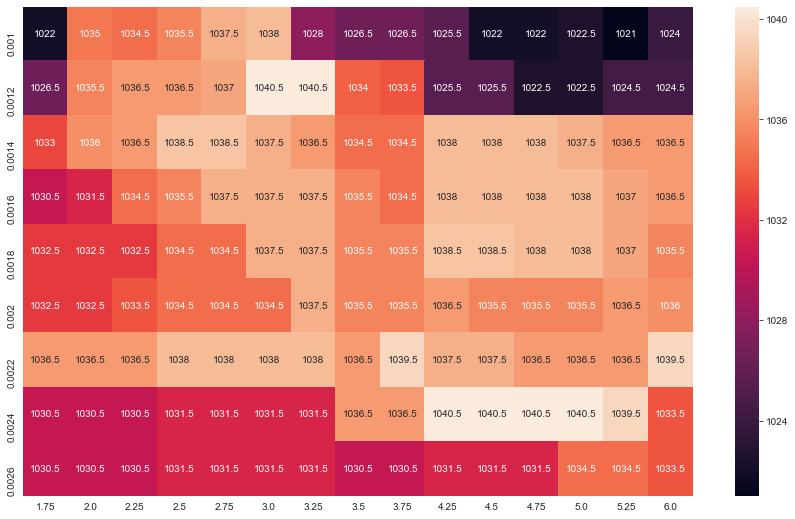

In [275]:
# setting avg = .015
# August 3+, lower bound = (.003, 0) average based in current
to_plot = create_metrics_grid_joe(df = august_only, 
                                  moving_avg_type = 'simple',
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=0)

plot_heatmap(to_plot)

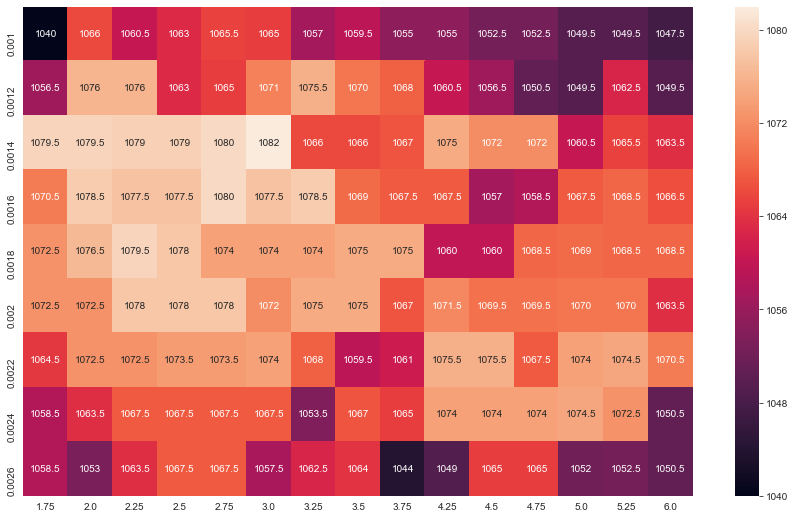

In [268]:
# August 3+, lower bound = (.003, 0) average based in current
to_plot = create_metrics_grid_joe(df = dai, 
                                  moving_avg_type = 'simple',
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=0)

plot_heatmap(to_plot)

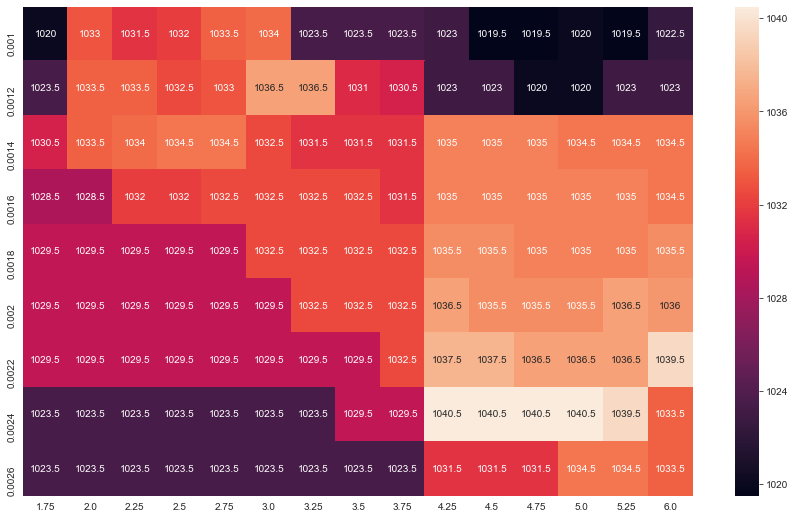

In [269]:
# August 3+, lower bound = (.003, 0), average based on shift
to_plot = create_metrics_grid_joe(df = august_only, 
                                  moving_avg_type = 'simple',
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=0)

plot_heatmap(to_plot)

Optimals

full data

Joe model 1075ish @ 3hr MA simple, .15%, 0/.3%

joe_model 1077ish @ 4.625 hr exp, .13%, 0/.3%

8/2 +

Joe model 1046ish @ 4.75 simple, .24%, 0/.3%

Joe_model 1044ish @ 4 exp, .21%, 0/.3%

8/3 +

Joe model 1046ish @ 4.75 simple, .24%, 0/.3%



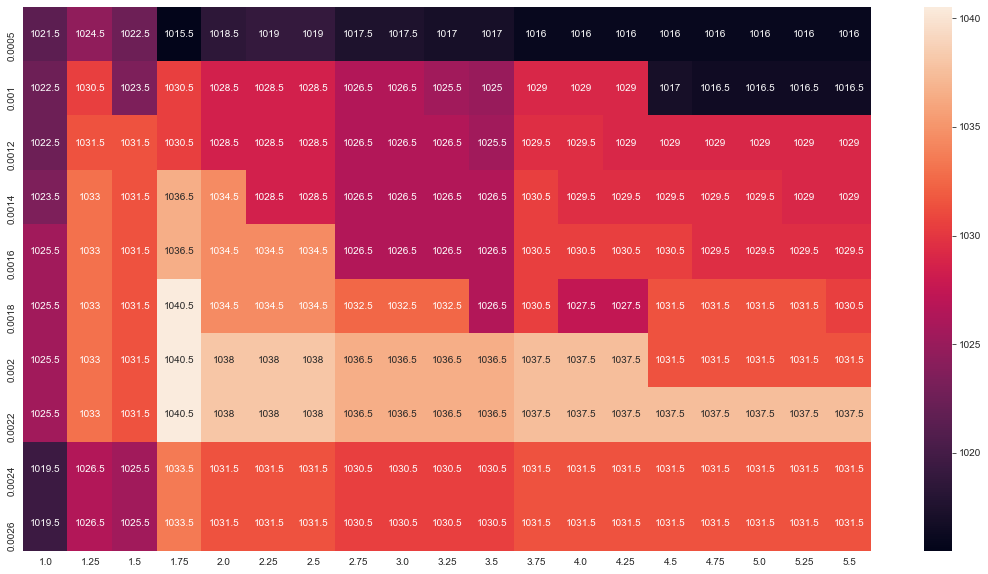

In [98]:
# August only, lower bound = (.003, 0), exp moving avg
to_plot = create_metrics_grid_joe(df = august_only, 
                                  moving_avg_type='exp',
                                  moving_avg_hrs=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5], 
                                  above_avg_bounds=[.0005, .001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=0)

plot_heatmap(to_plot)

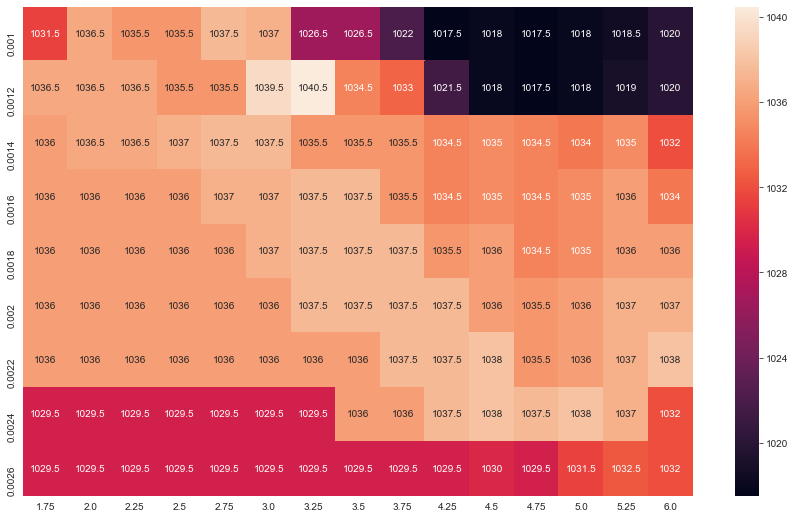

In [50]:
# August only, lower bound = (.003, -.001) dd
to_plot = create_metrics_grid_joe(df = august_only, 
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=-.001)

plot_heatmap(to_plot)

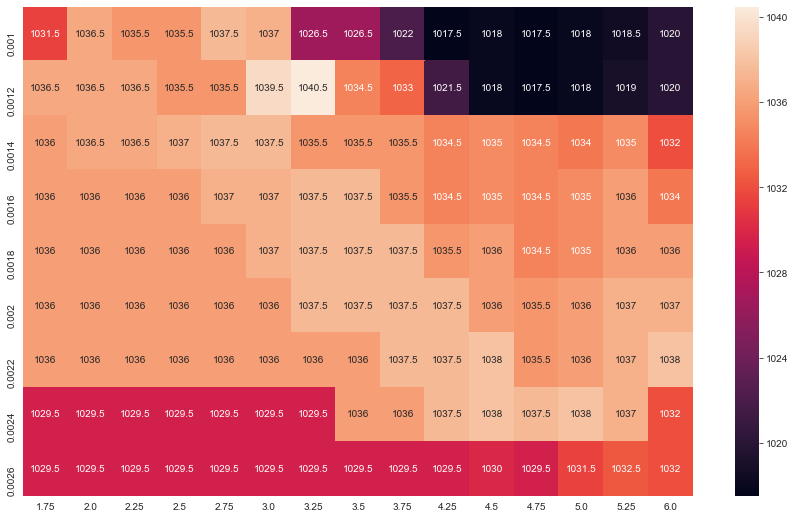

In [51]:
# August only, lower bound = (.003, -.001) * changed function so mean is of buy price
to_plot = create_metrics_grid_joe(df = august_only, 
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=-.001)

plot_heatmap(to_plot)

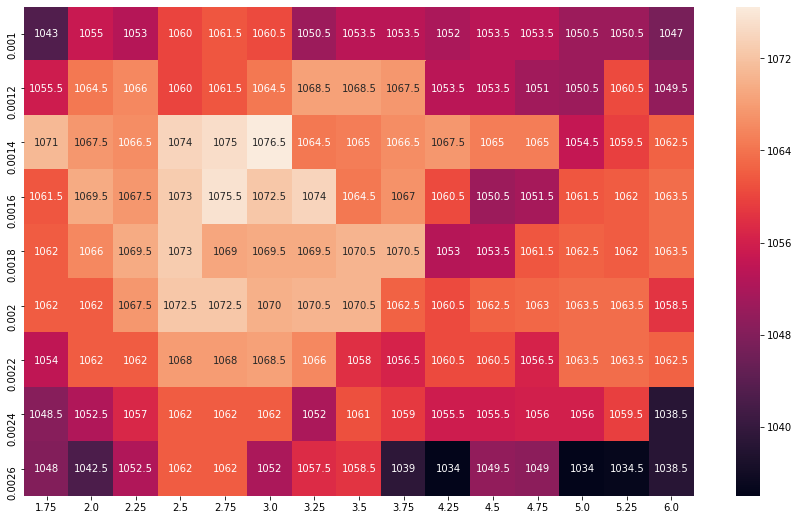

In [35]:
# Full time length, lower bound = (.3, 0)
to_plot = create_metrics_grid_joe(df = dai, 
                                  moving_avg_hrs=[1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4.25, 4.5, 4.75, 5, 5.25, 6], 
                                  above_avg_bounds=[.001, .0012, .0014, .0016, .0018, .002, .0022, .0024, .0026], 
                                  below_avg_upper_bound=.003, 
                                  below_avg_lower_bound=0)

plot_heatmap(to_plot)

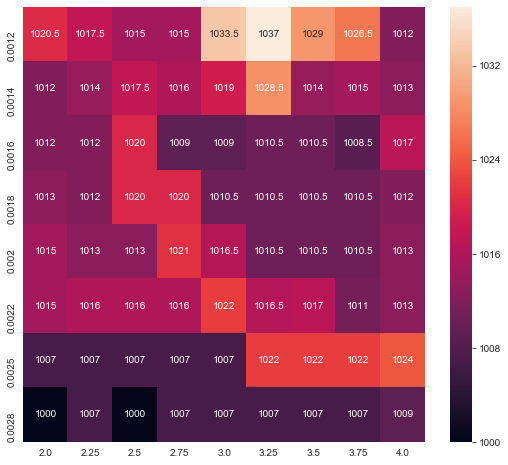

In [82]:
to_plot = create_metrics_grid(df=august_only,
                            target_diff=[.0012, .0014, .0016, .0018, .002, .0022, .0025, .0028],
                            moving_avg_hrs=[2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4],
                            fun='swing_calc',
                            boundary_spread = 0)

plot_heatmap(to_plot)

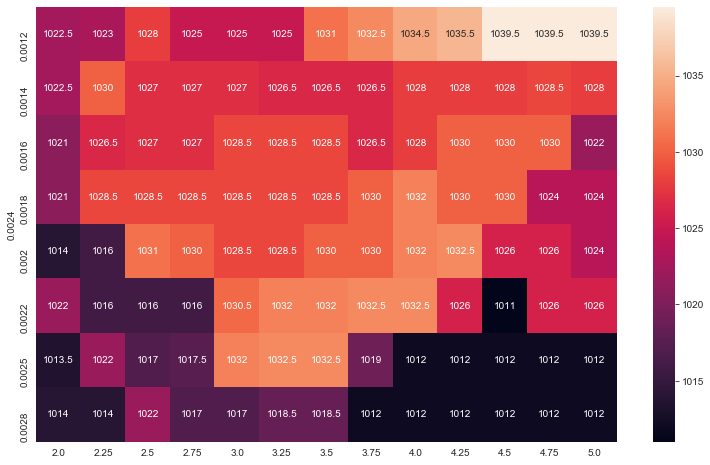

In [47]:
to_plot = create_metrics_grid(df=august_only,
                            target_diff=[.0012, .0014, .0016, .0018, .002, .0022, .0025, .0028],
                            moving_avg_hrs=[2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5],
                            fun='swing_calc',
                            boundary_spread = 0.0024)

plot_heatmap(to_plot)

In [96]:
#joe_wallet = joe_model(df=dai, is_dai=1, moving_avg_hrs=3.5, above_avg_upper_bound=.0015, above_avg_lower_bound=.0015, below_avg_upper_bound=.003, below_average_lower_bound=0, result_format='ending_wallet')
#std_wallet = swing_calc(df=dai, is_dai=0, target_diff=.0015, moving_avg_hrs=3, starting_bank=1000, boundary_spread=0, result_format='ending_wallet')

joe_log = joe_model(df=august_only, moving_avg_type='simple', moving_avg_hrs=4.75, above_avg_upper_bound=.0024, above_avg_lower_bound=.0024, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='dai', result_format='trade_log')
#joe_log_extended = joe_model(df=august_only, moving_avg_type='simple', moving_avg_hrs=4.75, above_avg_upper_bound=.0024, above_avg_lower_bound=.0024, below_avg_upper_bound=.004, below_avg_lower_bound=0, start_coin='usdc', result_format='trade_log')
#std_log = swing_calc(df=dai, is_dai=0, target_diff=.0015, moving_avg_hrs=3, starting_bank=1000, boundary_spread=0, result_format='trade_log')


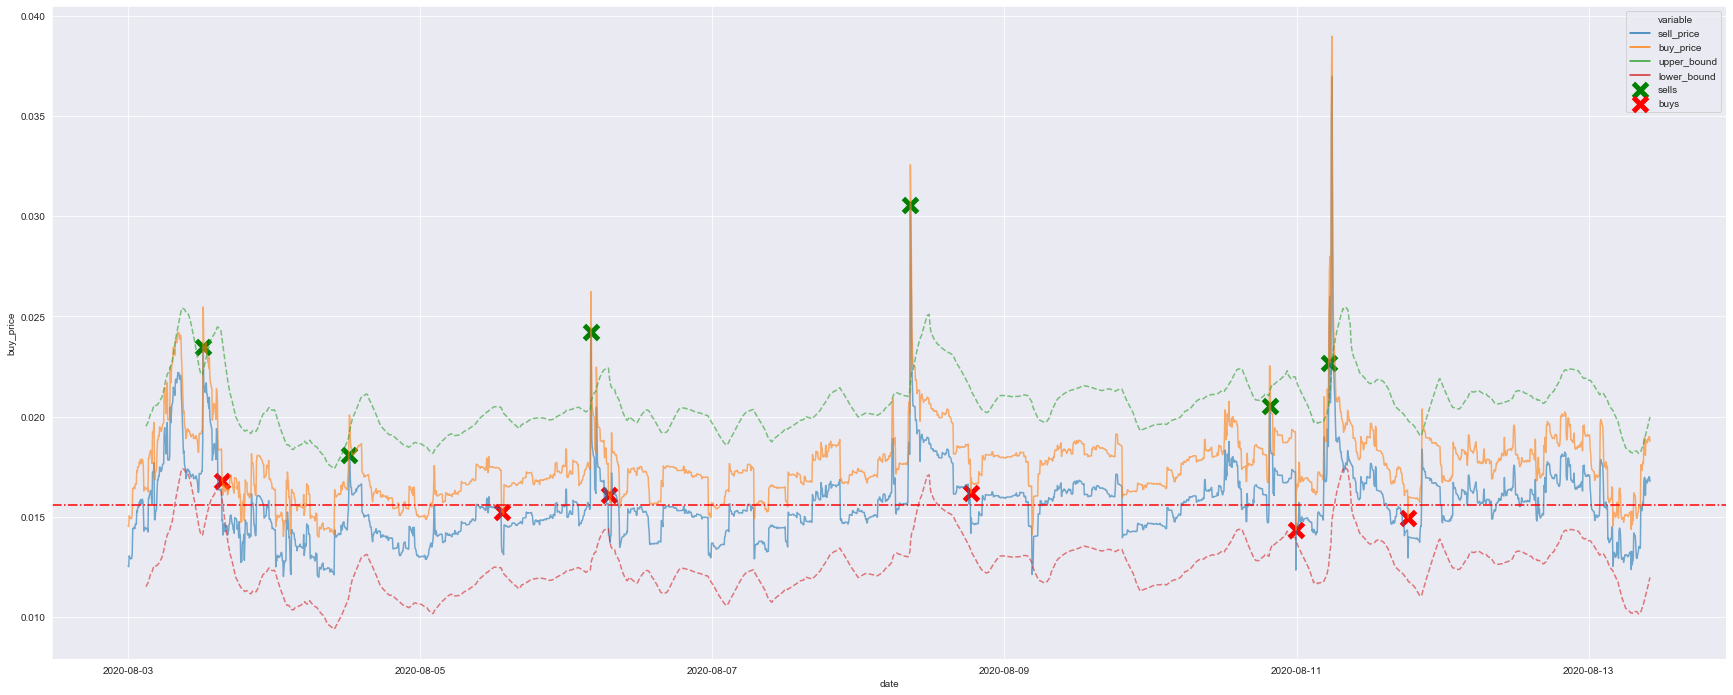

In [97]:
plot_trade_log(august_only, .003, 3, joe_log, 'historic_avg')

In [58]:
trade_log = joe_model_minmax(df=august_only, moving_avg_type='simple', moving_avg_hrs=5.75, above_avg_upper_bound=1, above_avg_lower_bound=1, below_avg_upper_bound=1, below_avg_lower_bound=1, start_coin='dai', starting_bank=1000, result_format='trade_log')
plot_trade_log(august_only, .0024, 6, trade_log, 'historic_avg')

TypeError: joe_model_minmax() got an unexpected keyword argument 'moving_avg_hrs'

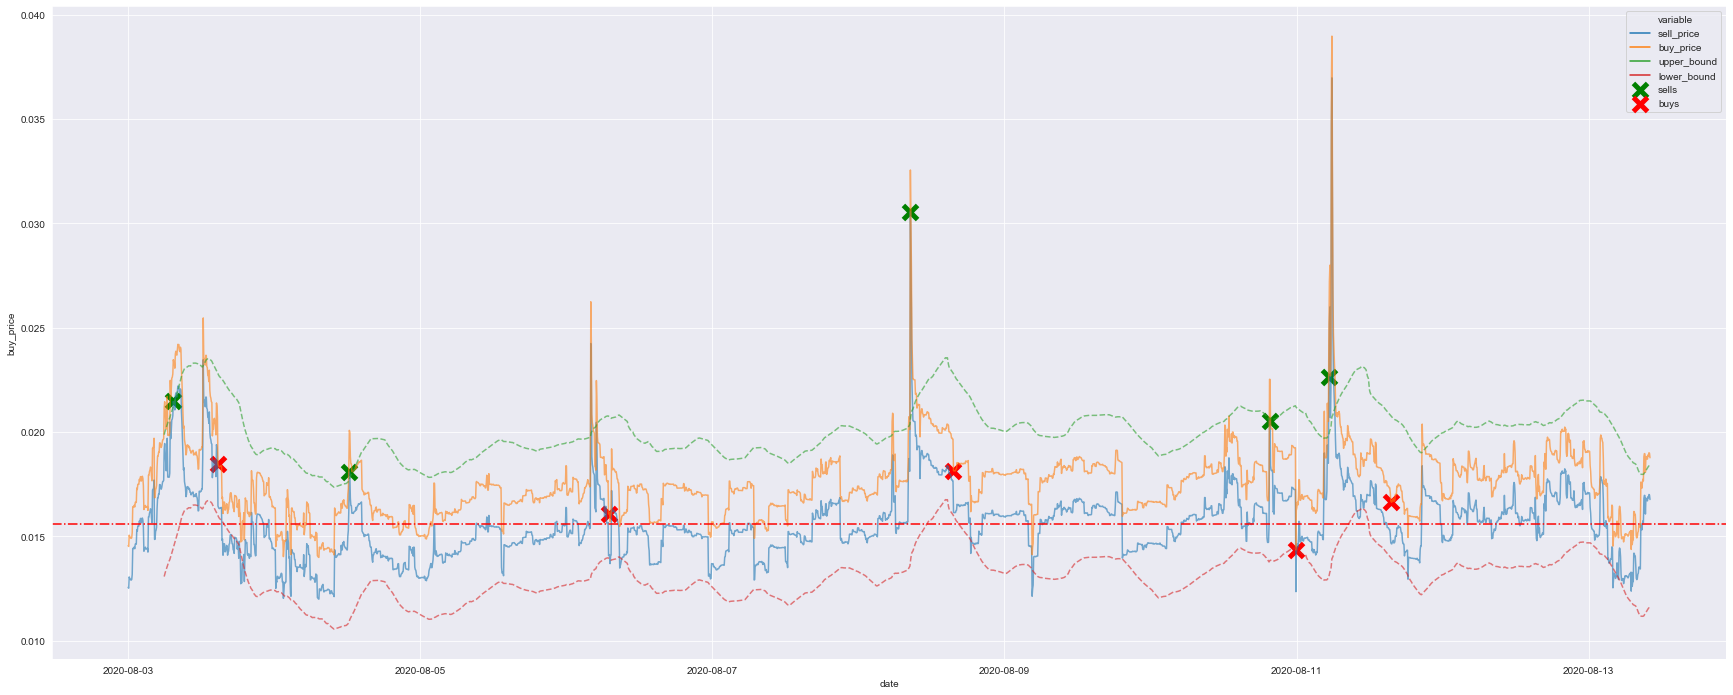

In [59]:
plot_trade_log(august_only, .0024, 6, trade_log, 'historic_avg')

In [10]:
# want range from .24 upper .24 lower
#                  .3 upper   0 lower


# No dividing line but can try different upper bound vs lower bound, just use below_avg_upper/below_avg_lower
def joe_model_no_split(df, moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'):
    '''
    inputs: df: df or prices and dates
            start_coin: 'dai', 'usdc', or 'cross_validate'. 'cross validate runs the function for both starting coins and returns the mean
            dai: 1 for dai, 0 for USDC
            amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
            target_diff: distance from moving avg's to set upper and lower trading bounds
            moving_avg_hrs: time period in hours for moving average
            boundary_spread: desired distance between target_diff for buys and sells
    result_format options : 'ending_wallet', 'trade_log','num_trades' 
    '''
    
    if start_coin == 'cross_validate' and result_format != 'ending_wallet':
        raise ValueError('Cross validation only works with ending wallet result')

    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries based on moving average using inputs
    df2 = create_boundaries_joe(df, moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound)
    historic_avg = df2['sell_price'].mean()

    # Initialize starting banks
    # For starting with Dai
    dai_bank = starting_bank
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0

    for (i, row) in df2.iterrows():
        # If market is low
        
        # If price above upper bound and own dai
        if row['sell_price'] > row['below_avg_upper_bound'] and dai_bank != 0:
            # Sell dai
            dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
        # If price below lower bound and own usdc
        elif row['buy_price'] < row['below_avg_lower_bound'] and usdc_bank != 0:
            # Buy dai
            dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
        
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            elif start_coin == 'usdc':
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        # if cross validating run second function with usdc start and average results
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, joe_model(df, moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='usdc', starting_bank=starting_bank, result_format='ending_wallet')])

        return ending_wallet_dai_value

In [37]:
# This version uses MinMax scaling for the prices
def create_boundaries_joe_minmax(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound):
    '''
    df: df of dates and prices and creates boundaries based on input
    target_diff: boundaries relative to price that we want to execute trades
    moving_avg_hrs: num hours to base moving average on
    boundary_spread: gap between buy target_diff and sell target_diff, 
                     if positive, shifts both bounds upwards (buy more frequently, sell less frequently)
                     if negative, shifts both bounds downwards (sell more frequently, buy less frequently)
    '''
    # Work on copy of df
    df2 = df.copy()

    # split price cols into buy and sell side with .002 gap
    df2.columns = ['date','sell_price']
    df2['buy_price'] = df2['sell_price'] + .002

    # Min Max scaling
    #df2['sell_price_scaled'] = (df2['sell_price'] - df2['sell_price'].min()) / (df2['sell_price'].max() - df2['sell_price'].min())
    #df2['buy_price_scaled'] = (df2['buy_price'] - df2['buy_price'].min()) / (df2['buy_price'].max() - df2['buy_price'].min())

    # How many 5 minute intervals
    sell_mvg_avg_interval = int(round(sell_mvg_avg_hrs * 60 / 5, 0))
    buy_mvg_avg_interval = int(round(buy_mvg_avg_hrs * 60 / 5, 0))
    
    # Set moving averages
    if sell_mvg_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_mvg_avg_interval).mean()
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).mean()

    elif sell_mvg_avg_type == 'exp':
        # Exponential moving avg
        df2['moving_avg_mid_sell'] = df2['sell_price'].ewm(span=sell_mvg_avg_interval, min_periods=sell_mvg_avg_interval).mean()
        df2['moving_avg_mid_buy'] = df2['buy_price'].ewm(span=buy_mvg_avg_interval, min_periods=buy_mvg_avg_interval).mean()
    elif sell_mvg_avg_type == 'median':
        # Median
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_mvg_avg_interval).median()
    else:
        raise ValueError("Don't recognize sell moving average type")

    if buy_mvg_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).mean()

    elif buy_mvg_avg_type == 'exp':
        # Exponential moving avg
        df2['moving_avg_mid_buy'] = df2['buy_price'].ewm(span=buy_mvg_avg_interval, min_periods=buy_mvg_avg_interval).mean()
    
    elif buy_mvg_avg_type == 'median':
        # Median
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_mvg_avg_interval).median()
    else:
        raise ValueError("Don't recognize buy moving average type")
 

    # Scale price features
    historic_avg_buy_price = df2['buy_price'].mean()
    historic_avg_sell_price = df2['sell_price'].mean()
    price_is_hi_mask = df2['buy_price'] > historic_avg_buy_price
    price_is_lo_mask = df2['sell_price'] <= historic_avg_sell_price

    # Get the min max scaling for buy and sell prices, using a range from min price to mean for lo prices and mean to max price for hi prices
    df2.loc[price_is_hi_mask, 'sell_price_scaled'] = (df2.loc[price_is_hi_mask, 'sell_price'] - df2.loc[price_is_hi_mask, 'sell_price'].min()) / (df2.loc[price_is_hi_mask, 'sell_price'].max() - df2.loc[price_is_hi_mask, 'sell_price'].min())
    df2.loc[price_is_hi_mask, 'buy_price_scaled'] = (df2.loc[price_is_hi_mask, 'buy_price'] - df2.loc[price_is_hi_mask, 'buy_price'].min()) / (df2.loc[price_is_hi_mask, 'buy_price'].max() - df2.loc[price_is_hi_mask, 'buy_price'].min())
    df2.loc[price_is_lo_mask, 'sell_price_scaled'] = (df2.loc[price_is_lo_mask, 'sell_price'] - df2.loc[price_is_lo_mask, 'sell_price'].min()) / (df2.loc[price_is_lo_mask, 'sell_price'].max() - df2.loc[price_is_lo_mask, 'sell_price'].min())
    df2.loc[price_is_lo_mask, 'buy_price_scaled'] = (df2.loc[price_is_lo_mask, 'buy_price'] - df2.loc[price_is_lo_mask, 'buy_price'].min()) / (df2.loc[price_is_lo_mask, 'buy_price'].max() - df2.loc[price_is_lo_mask, 'buy_price'].min())
    
    # # Set up boundary trigger points
    # # Price is hi
    # df2.loc[price_is_hi_mask, 'upper_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_buy'] + .003 - .003 * df2.loc[price_is_hi_mask, 'buy_price_scaled']  # This makes sure that the min price has a upper bound of .0015 and max price has upper bound of 0
    # df2.loc[price_is_hi_mask, 'lower_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_sell'] - 0 - .003 * df2.loc[price_is_hi_mask, 'sell_price_scaled']          # This makes sure that the min price has a lower bound of .0015 and max price has lower bound of .003

    # # Price is lo
    # df2.loc[price_is_lo_mask, 'upper_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_buy'] + .003 
    # df2.loc[price_is_lo_mask, 'lower_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_sell'] - 0 

    # Set up boundary trigger points
    # Price is hi
    df2.loc[price_is_hi_mask, 'upper_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_buy'] + below_avg_upper_bound - (below_avg_upper_bound - above_avg_upper_bound) * df2.loc[price_is_hi_mask, 'buy_price_scaled']  # This makes sure that the min price has a upper bound equal to the below avg upper bound and when price is max, upper bound equals the upper bound input 
    df2.loc[price_is_hi_mask, 'lower_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_sell'] - below_avg_lower_bound + (below_avg_lower_bound - above_avg_lower_bound) * df2.loc[price_is_hi_mask, 'sell_price_scaled']          # This makes sure that the min price has a lower bound equal to the below avg lower bound and when price is max, lower bound equals the lower bound input 

    # Price is lo
    df2.loc[price_is_lo_mask, 'upper_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_buy'] + below_avg_upper_bound 
    df2.loc[price_is_lo_mask, 'lower_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_sell'] - below_avg_lower_bound

    # above_avg upper = 0
    # above_avg lower = .003
    # below avg upper = .003
    # below avg lower = 0

    # # Set up boundary trigger points
    # # Price is hi
    # df2.loc[price_is_hi_mask, 'upper_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_buy'] + .0015 - .0015 * df2.loc[price_is_hi_mask, 'buy_price_scaled']  # This makes sure that the min price has a upper bound of .0015 and max price has upper bound of 0
    # df2.loc[price_is_hi_mask, 'lower_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_sell'] + .0015 + .0015 * df2.loc[price_is_hi_mask, 'sell_price_scaled']          # This makes sure that the min price has a lower bound of .0015 and max price has lower bound of .003

    # # Price is lo
    # df2.loc[price_is_lo_mask, 'upper_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_buy'] + .003 - .0015 * df2.loc[price_is_lo_mask, 'buy_price_scaled']  # This makes sure that the min price has a upper bound of .0015 and max price has upper bound of 0
    # df2.loc[price_is_lo_mask, 'lower_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_sell'] - 0 - .0015 * df2.loc[price_is_lo_mask, 'sell_price_scaled']          # This makes sure that the min price has a lower bound of .0015 and max price has lower bound of .003




#     # want range from 
#     #price is hi
# max    upper 0 lower .3
# mid    upper .15  lower .15

#     # price is lo
# min    upper .3 lower 0
# mid    upper .15  lower .15

    # # Set up boundary trigger points
    # df2['upper_bound'] = df2['moving_avg_mid_buy'] + .0025 - .0025 * df2['buy_price_scaled']  # This makes sure that the min price has a upper bound of .003 and max price has upper bound of 0
    # df2['lower_bound'] = df2['moving_avg_mid_sell'] + 0 + .0025 * df2['sell_price_scaled']  # This makes sure that the min price has lower bound of (near) 0 and max price has upper bound of .0024

    ### DONT NEED THIS FOR THIS VERSION
    df2['above_avg_upper_bound'] = df2['moving_avg_mid_buy'] + above_avg_upper_bound 
    df2['above_avg_lower_bound'] = df2['moving_avg_mid_sell'] - above_avg_lower_bound
    df2['below_avg_upper_bound'] = df2['moving_avg_mid_buy'] + below_avg_upper_bound 
    df2['below_avg_lower_bound'] = df2['moving_avg_mid_sell'] - below_avg_lower_bound

    ### DONT NEED THIS
    # Shift prices so we can compare price to the previous price to measure spikes
    df2['sell_price_shift'] = df2['sell_price'].shift(1)
    df2['buy_price_shift'] = df2['buy_price'].shift(1)

    return df2

# want range from  0 upper .3 lower
#                  .3 upper   0 lower
# Joes model
def joe_model_minmax(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'):
    '''
    inputs: df: df or prices and dates
            start_coin: 'dai', 'usdc', or 'cross_validate'. 'cross validate runs the function for both starting coins and returns the mean
            dai: 1 for dai, 0 for USDC
            amount: total value in DAI (if USDC is chosen the equivalent of x amount in DAI will be calculated)
            target_diff: distance from moving avg's to set upper and lower trading bounds
            moving_avg_hrs: time period in hours for moving average
            boundary_spread: desired distance between target_diff for buys and sells
    result_format options : 'ending_wallet', 'trade_log','num_trades' 
    '''
    
    if start_coin == 'cross_validate' and result_format != 'ending_wallet':
        raise ValueError('Cross validation only works with ending wallet result')

    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','Index','DAI','USDC','Current price'])

    # Add in boundaries based on moving average using inputs
    df2 = create_boundaries_joe_minmax(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound)
    historic_avg = df2['sell_price'].mean()

    # Initialize starting banks
    # For starting with Dai
    dai_bank = starting_bank
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (1 + df2.iloc[0]['sell_price'])
        dai_bank = 0

    for (i, row) in df2.iterrows():

        # If price above upper bound and own dai
        if row['sell_price'] > row['upper_bound'] and dai_bank != 0:
            # Sell dai
            dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
        # If price below lower bound and own usdc
        elif row['buy_price'] < row['lower_bound'] and usdc_bank != 0:
            # Buy dai
            dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)

        
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            elif start_coin == 'usdc':
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (1 + df2.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['USDC'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['DAI'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['USDC'] / (1 + trades.iloc[-1]['Current price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        # if cross validating run second function with usdc start and average results
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, joe_model_minmax(df, sell_mvg_avg_type, buy_mvg_avg_type, sell_mvg_avg_hrs, buy_mvg_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound, start_coin='usdc', starting_bank=starting_bank, result_format='ending_wallet')])

        return ending_wallet_dai_value

# INCOMPLETE   
def create_metrics_grid_joe(df, moving_avg_type, moving_avg_hrs, above_avg_bounds, below_avg_upper_bound, below_avg_lower_bound):
    
    col = []
    for bound in above_avg_bounds:
        row=[]
        for hr in moving_avg_hrs:
            row.append(joe_model(df=df, moving_avg_type=moving_avg_type, moving_avg_hrs=hr, above_avg_upper_bound=bound, above_avg_lower_bound=bound, below_avg_upper_bound=below_avg_upper_bound, below_avg_lower_bound=below_avg_lower_bound))
        col.append(row)

    metrics_grid = pd.DataFrame(col, columns = moving_avg_hrs, index = above_avg_bounds)

    
    return metrics_grid

In [292]:
trade_log = joe_model_minmax(df=august_only, moving_avg_type='exp', moving_avg_hrs=4.75, above_avg_upper_bound=1, above_avg_lower_bound=1, below_avg_upper_bound=1, below_avg_lower_bound=1, start_coin='dai', starting_bank=1000, result_format='trade_log')

dynamic model does decent with .025 boundary for both, exp, 4.75h (1036.5). Try adjusting one on .025, one on .3, etc. Try changing the weights to the scaling isn't flat.

Problem is it's buying back too soon after drops, so try change scaling.

Maybe base it on distance from mean

2 diff moving avgs

In [57]:
joe_model_minmax(df=dai, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.25, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1075.0

In [63]:
test

KeyError: 139

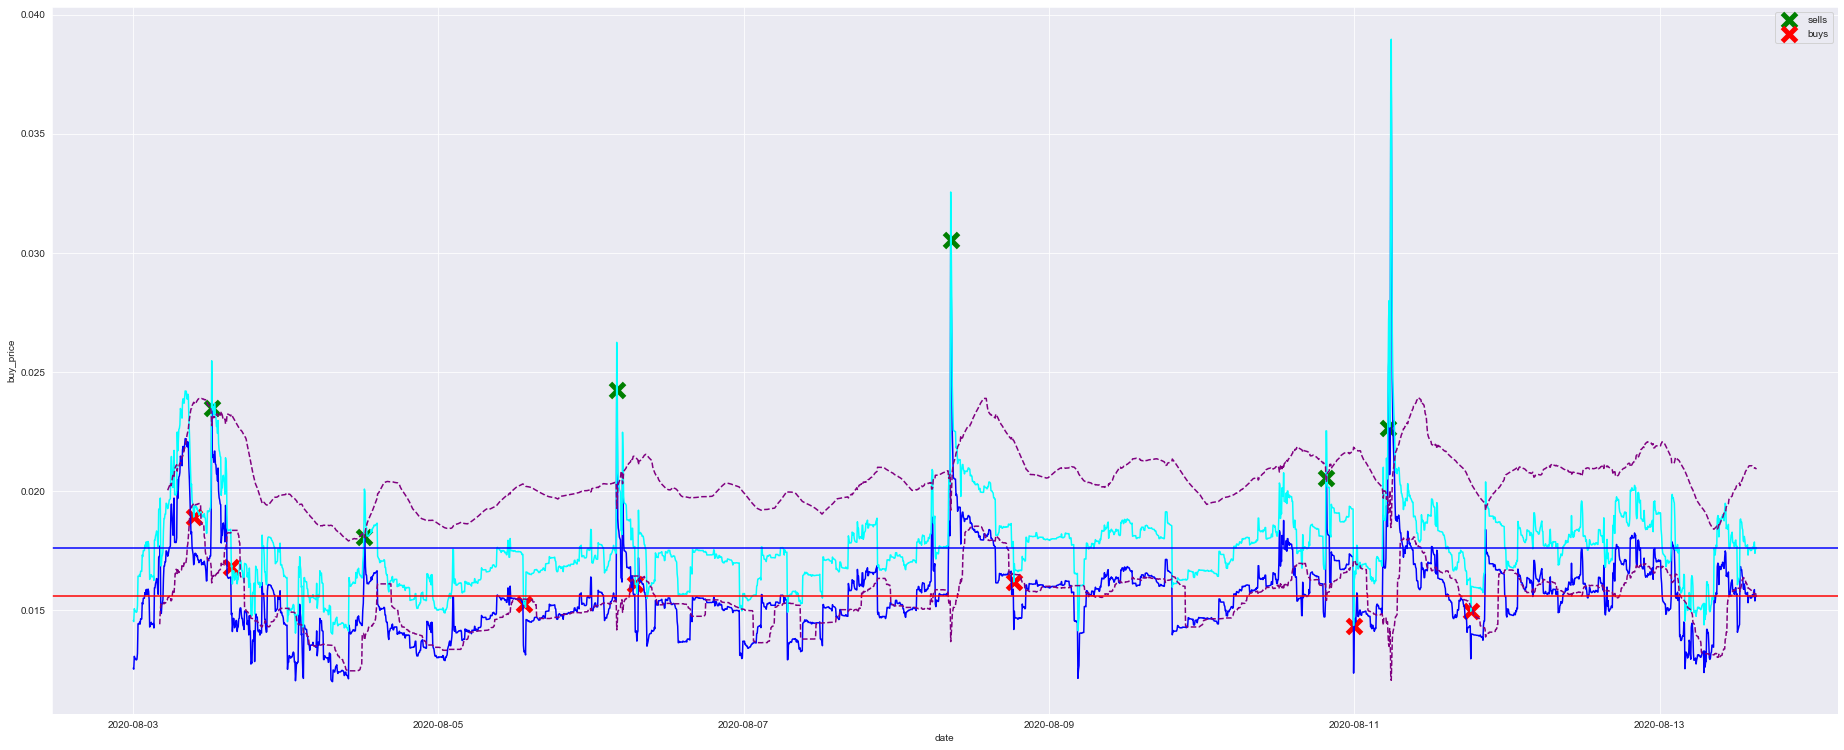

In [83]:
trade_log = joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='usdc', starting_bank=1000, result_format='trade_log')

trade_log2 = joe_model(df = august_only, moving_avg_type = 'simple',moving_avg_hrs=4.75, above_avg_upper_bound=.0024,above_avg_lower_bound=.0024, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='usdc', result_format='trade_log')

test = create_boundaries_joe_minmax(august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.25, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=0)[['date', 'sell_price','buy_price','upper_bound','lower_bound','buy_price_scaled','sell_price_scaled']]
sns.set_style('darkgrid')
plt.figure(figsize=(32, 13))
ax=sns.lineplot('date','sell_price', data = test, c='blue')
sns.lineplot('date','buy_price', data = test, c='cyan')
sns.lineplot('date','upper_bound', data = test, c='purple')
sns.lineplot('date','lower_bound', data = test, c='purple')
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.axhline(test['sell_price'].mean(), c='r')
ax.axhline(test['buy_price'].mean(), c='b')

 # Get index of trades
sells = trade_log[trade_log['buy_or_sell'] == 'sell']['Index']
buys = trade_log[trade_log['buy_or_sell'] == 'buy']['Index']

 # Get index of trades
sells2 = trade_log2[trade_log2['buy_or_sell'] == 'sell']['Index']
buys2 = trade_log2[trade_log2['buy_or_sell'] == 'buy']['Index']

# X marks the spot for trades
sns.scatterplot('date', 'sell_price', data = test.loc[sells], marker = 'x', color='green', s=200, alpha=1, linewidth=5, label='sells')
sns.scatterplot('date', 'buy_price', data = test.loc[buys], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label='buys')

# # X marks the spot for trades
# sns.scatterplot('date', 'sell_price', data = test.loc[sells2], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label='sells')
# sns.scatterplot('date', 'buy_price', data = test.loc[buys2], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label='buys')

plt.show()

In [91]:
joe_model(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=0.003, above_avg_lower_bound=0, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1025.0

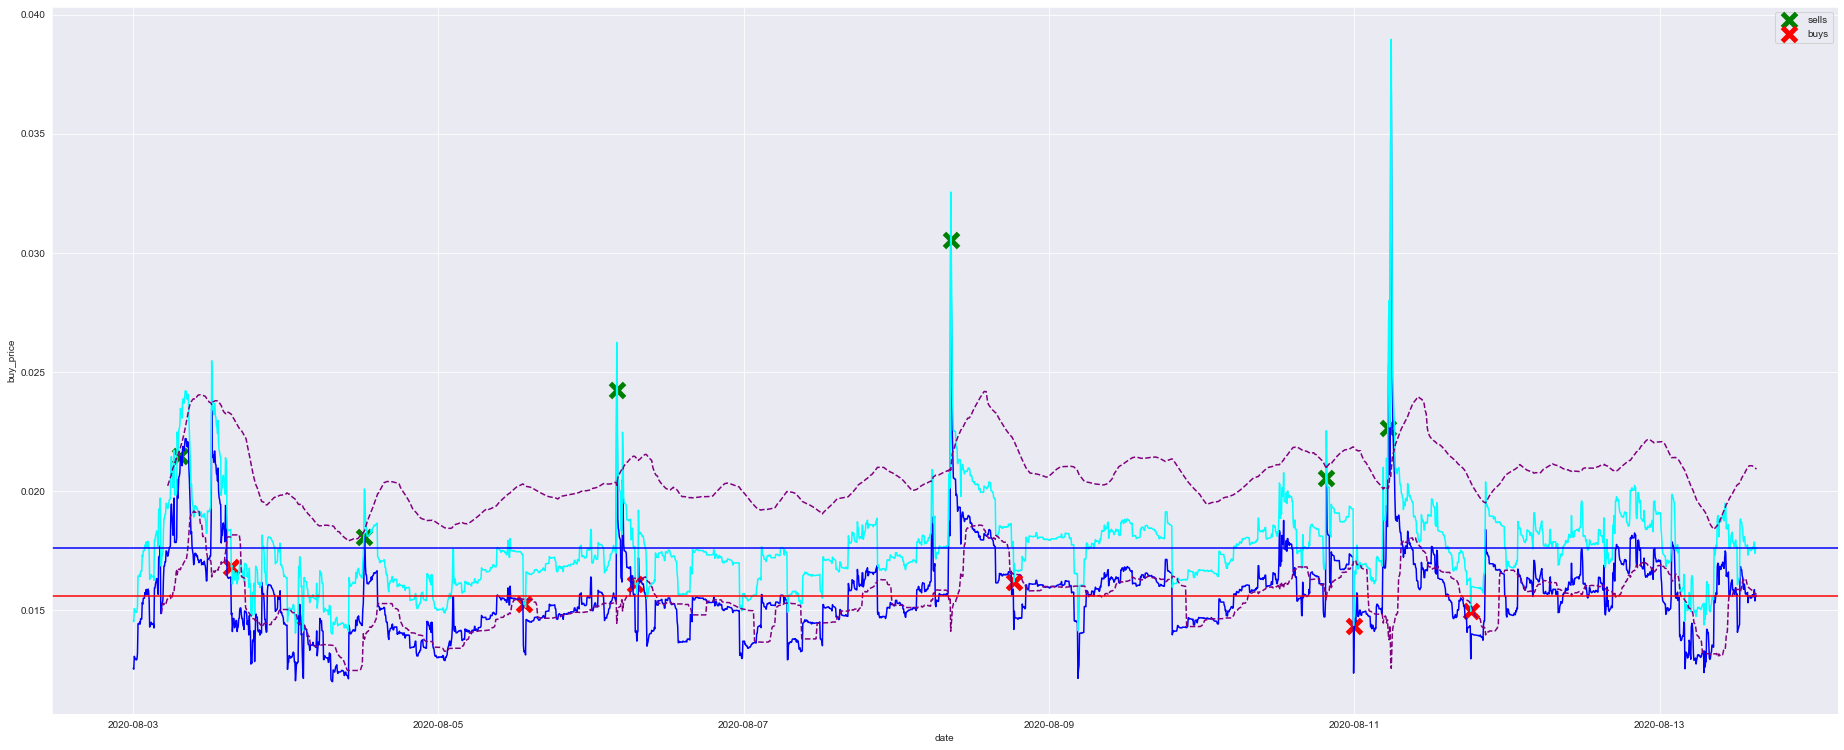

In [87]:
trade_log = joe_model(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=.0024, above_avg_lower_bound=.0024, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='dai', starting_bank=1000, result_format='trade_log')

test = create_boundaries_joe_minmax(august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=.0024, above_avg_lower_bound=.0024, below_avg_upper_bound=.003, below_avg_lower_bound=0)[['date', 'sell_price','buy_price','upper_bound','lower_bound','buy_price_scaled','sell_price_scaled']]
sns.set_style('darkgrid')
plt.figure(figsize=(32, 13))
ax=sns.lineplot('date','sell_price', data = test, c='blue')
sns.lineplot('date','buy_price', data = test, c='cyan')
sns.lineplot('date','upper_bound', data = test, c='purple')
sns.lineplot('date','lower_bound', data = test, c='purple')
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
ax.axhline(test['sell_price'].mean(), c='r')
ax.axhline(test['buy_price'].mean(), c='b')

 # Get index of trades
sells = trade_log[trade_log['buy_or_sell'] == 'sell']['Index']
buys = trade_log[trade_log['buy_or_sell'] == 'buy']['Index']

# X marks the spot for trades
sns.scatterplot('date', 'sell_price', data = test.loc[sells], marker = 'x', color='green', s=200, alpha=1, linewidth=5, label='sells')
sns.scatterplot('date', 'buy_price', data = test.loc[buys], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label='buys')
plt.show()



In [95]:
joe_model_minmax(df=august_only, moving_avg_type='simple', sell_mvg_avg_hrs=5.75, buy_mvg_avg_hrs=6.25, above_avg_upper_bound=1, above_avg_lower_bound=1, below_avg_upper_bound=1, below_avg_lower_bound=1, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1031.5

In [57]:
trade_log = joe_model_minmax(df=august_only, moving_avg_type='simple', sell_mvg_avg_hrs=8, buy_mvg_avg_hrs=5.75, above_avg_upper_bound=1, above_avg_lower_bound=1, below_avg_upper_bound=1, below_avg_lower_bound=1, start_coin='dai', starting_bank=1000, result_format='trade_log')

In [33]:
joe_model_minmax(df=august_only, moving_avg_type='simple', sell_mvg_avg_hrs=5.75, buy_mvg_avg_hrs=5.75, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=-.001, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1035.0

In [43]:
joe_model_minmax(df=august_only, moving_avg_type='exp', sell_mvg_avg_hrs=2.5, buy_mvg_avg_hrs=2.5, above_avg_upper_bound=1, above_avg_lower_bound=1, below_avg_upper_bound=1, below_avg_lower_bound=1, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1038.5

In [300]:
joe_model(df=dai, moving_avg_type='simple', moving_avg_hrs=3, above_avg_upper_bound=.0015, above_avg_lower_bound=.0015, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')

1083.5

In [42]:
# Grid search for optimal parameters
results = []
for sell_mvg_avg_type in ['simple','exp','median']:
    for buy_mvg_avg_type in ['simple','exp','median']:
        for sell_mvg_avg_hrs in [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]:
            for buy_mvg_avg_hrs in [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]:
                dict = {}
                dict['sell_type'] = sell_mvg_avg_type
                dict['buy_type'] = buy_mvg_avg_type
                dict['sell_hrs'] = sell_mvg_avg_hrs
                dict['buy_hrs'] = buy_mvg_avg_hrs
                dict['result'] = joe_model_minmax(df=august_only, sell_mvg_avg_type=sell_mvg_avg_type, buy_mvg_avg_type=buy_mvg_avg_type, sell_mvg_avg_hrs=sell_mvg_avg_hrs, buy_mvg_avg_hrs=buy_mvg_avg_hrs, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
                results.append(dict)

In [73]:
# Grid search for optimal parameters
results = []
for above_avg_upper_bound in [-.002, -.0015, -.001, -.005, 0, .005, .001, .0015, .002]:
    for above_avg_lower_bound in [.0015, .002, .0025, .003, .0035, .004, .0045]:
        for below_avg_upper_bound in [.0015, .002, .0025, .003, .0035, .004, .0045]:
            for below_avg_lower_bound in [-.002, -.0015, -.001, -.005, 0, .005, .001, .0015, .002]:
                dict = {}
                dict['above_upper'] = above_avg_upper_bound
                dict['above_lower'] = above_avg_lower_bound
                dict['below_upper'] = below_avg_upper_bound
                dict['below_lower'] = below_avg_lower_bound
                dict['result'] = joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.25, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=above_avg_upper_bound, above_avg_lower_bound=above_avg_lower_bound, below_avg_upper_bound=below_avg_upper_bound, below_avg_lower_bound=below_avg_lower_bound, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
                results.append(dict)



In [45]:

results[max(range(len(results)), key=lambda index: results[index]['result'])]

{'sell_type': 'median',
 'buy_type': 'simple',
 'sell_hrs': 4.5,
 'buy_hrs': 5.5,
 'result': 1044.5}

In [80]:
print(joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=-.0015, above_avg_lower_bound=.0045, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'))

print(joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=-.001, above_avg_lower_bound=.0045, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'))

print(joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=4.5, buy_mvg_avg_hrs=5.5, above_avg_upper_bound=0, above_avg_lower_bound=.0045, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'))

1044.5
1044.5
1044.5


In [49]:
# Grid search for optimal parameters
results = []
for sell_mvg_avg_hrs in [2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5]:
    for buy_mvg_avg_hrs in [5.25, 5.5, 5.75, 6, 6.25]:
        dict = {}
        dict['sell_type'] = sell_mvg_avg_type
        dict['buy_type'] = buy_mvg_avg_type
        dict['sell_hrs'] = sell_mvg_avg_hrs
        dict['buy_hrs'] = buy_mvg_avg_hrs
        dict['result'] = joe_model_minmax(df=august_only, sell_mvg_avg_type='median', buy_mvg_avg_type='simple', sell_mvg_avg_hrs=sell_mvg_avg_hrs, buy_mvg_avg_hrs=buy_mvg_avg_hrs, above_avg_upper_bound=0, above_avg_lower_bound=.003, below_avg_upper_bound=.003, below_avg_lower_bound=0, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
        results.append(dict)

In [74]:
nlargest(10, results, key=lambda item: item["result"])

[{'above_upper': -0.0015,
  'above_lower': 0.0045,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': -0.001,
  'above_lower': 0.0045,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': 0,
  'above_lower': 0.0045,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': 0.001,
  'above_lower': 0.0045,
  'below_upper': 0.0025,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': 0.0015,
  'above_lower': 0.0045,
  'below_upper': 0.0025,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': 0.002,
  'above_lower': 0.0045,
  'below_upper': 0.0025,
  'below_lower': 0,
  'result': 1043.5},
 {'above_upper': -0.0015,
  'above_lower': 0.0025,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1043.0},
 {'above_upper': -0.0015,
  'above_lower': 0.003,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1043.0},
 {'above_upper': -0.0015,
  'above_lower': 0.0035,
  'below_upper': 0.003,
  'belo